# 1. Configuration

In [75]:
import os
import gc
import cv2
import copy
import random
import numpy as np
import pandas as pd
import polars as pl
from pathlib import Path
import typing as tp
from io import BytesIO
from PIL import Image
import h5py
import timm
from time import time
from tqdm.notebook import tqdm
import shutil
import pickle

import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import VotingClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

import lightgbm as lgb
import catboost as cb
import xgboost as xgb

import optuna
import wandb
import torch
import torchvision
from torch import nn
from torch import optim
from torch.optim import lr_scheduler
from torch import amp
from torch.utils.data import Dataset
import torch.nn.functional as F
import albumentations as A
from albumentations.pytorch import ToTensorV2

pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

In [76]:
class CFG:
    
    exp = 46
    
    is_kaggle = False
    is_infer = False
    enable_wandb = True
    if is_kaggle:
        OUTPUT_DIR = Path('/kaggle/input/isic2024-baseline')
        TRAIN_DIR = Path('/kaggle/input/isic-2024-challenge/train-image/image')
        TRAIN_HDF5 = Path('/kaggle/input/isic-2024-challenge/train-image.hdf5')
        TEST_HDF5 = Path('/kaggle/input/isic-2024-challenge/test-image.hdf5')
        TRAIN_META = Path('/kaggle/input/isic-2024-challenge/train-metadata.csv')
        TEST_META = Path('/kaggle/input/isic-2024-challenge/test-metadata.csv')
        SAMPLE_SUB = Path('/kaggle/input/isic-2024-challenge/sample_submission.csv')
        PRETRAINED_MODEL = ''
        
    else:
        OUTPUT_DIR = Path(f'/root/Development/Kaggle/ISIC2024/main/models/experiments/exp{exp}/outputs')
        OUTPUT_LOG = Path(f'/root/Development/Kaggle/ISIC2024/main/models/experiments/exp{exp}/log.txt')
        TRAIN_DIR = Path('/root/Development/Kaggle/ISIC2024/data/raw/train-image/image')
        TRAIN_HDF5 = Path('/root/Development/Kaggle/ISIC2024/data/raw/train-image.hdf5')
        TEST_HDF5 = Path('/root/Development/Kaggle/ISIC2024/data/raw/test-image.hdf5')
        TRAIN_META = Path('/root/Development/Kaggle/ISIC2024/data/raw/train-metadata.csv')
        TEST_META = Path('/root/Development/Kaggle/ISIC2024/data/raw/test-metadata.csv')
        SAMPLE_SUB = Path('/root/Development/Kaggle/ISIC2024/data/raw/sample_submission.csv')
        TRAIN_META_ADD = Path('/root/Development/Kaggle/ISIC2024/data/external/All/metadata.csv')
        TRAIN_HDF5_ADD = Path('/root/Development/Kaggle/ISIC2024/data/external/All/image.hdf5')
        TRAIN_HDF5_COMBINED = Path('/root/Development/Kaggle/ISIC2024/data/processed/train-image-combined.hdf5')
        # PRETRAINED_MODEL = ''
        PRETRAINED_MODEL = Path('/root/Development/Kaggle/ISIC2024/main/models/experiments/exp32/outputs/averaged_model.pth')
    
    es_patience = 5
    batch_size = 128 # 256
    max_epoch = 9
    n_folds = 5
    n_classes = 2
    random_seed = 42
    lr = 1.0e-04 # lr = 1.0e-03
    weight_decay = 1.0e-02 # default
    deterministic = True
    enable_amp = True
    view = True
    change_dataset = True
    standardization = True
    oversampling = False
    oversampling_percent = 3
    only_lesion_id = False
    alldata_isic_archive = False
    test_of_averaged_model = False
    train_with_fewdata: int|bool = False
    # train_with_fewdata: int|bool = 100000 # or False
    pretrained = True
    TTA: bool = True
    TTA_rate = {'None':0.7, 'with_train_aug':0.3}
    AUX_LOSS = False
    use_tabler = True
    image_pred_as_tabler_feature = False
    ensemble_image_table = True
    
    model_name = 'maxvit_rmlp_pico_rw_256.sw_in1k'
    output_dim_models = { 
        "resnet18.a1_in1k": 512,
        "efficientnet_b0.ra_in1k": 320,
        "tf_efficientnet_b0.ns_jft_in1k": 1280,
        # 'tf_efficientnet_b5.ns_jft_in1k': 1280,
        'tf_efficientnet_b3.ns_jft_in1k': 1536,
        'eva02_large_patch14_224.mim_in22k': 384,
        'eva02_large_patch14_448.mim_m38m_ft_in22k_in1k': 384,
        'maxvit_tiny_tf_224.in1k': 256,
        'maxvit_rmlp_nano_rw_256.sw_in1k': 256,
        'maxvit_rmlp_pico_rw_256.sw_in1k': 256,
        'maxvit_small_tf_224.in1k': 256,
    }
    
    # img_size = 224
    img_size = 256
    # img_size = 384
    interpolation = cv2.INTER_LINEAR
    
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
        
    
    wandb_config = {
    "es_patience" : es_patience,
    "batch_size" : batch_size, # 128 # 256
    "max_epoch" : max_epoch,
    "n_folds" : n_folds,
    "n_classes" : n_classes,
    "random_seed" : random_seed,
    "lr" : lr, # lr = 1.0e-04
    "weight_decay" : weight_decay, # default
    "deterministic" : deterministic,
    "enable_amp" : enable_amp,
    "view" : view,
    "change_dataset" : change_dataset,
    "standardization" : standardization,
    "oversampling" : oversampling,
    "oversampling_percent" : oversampling_percent,
    "only_lesion_id" : only_lesion_id,
    "alldata_isic_archive" : alldata_isic_archive,
    "test_of_averaged_model" : test_of_averaged_model,
    "train_with_fewdata" : train_with_fewdata, # 100000 or False
    "pretrained" : pretrained,
    "TTA" : TTA,
    "TTA_rate" : TTA_rate,
    "model_name" : model_name,
    "output_dim_models" : output_dim_models,
    "img_size" : img_size, # 224 # 256 # 384
    "interpolation" : interpolation,
    "AUX_LOSS" : AUX_LOSS,
    "use_tabler": use_tabler,
    "image_pred_as_tabler_feature": image_pred_as_tabler_feature,
    "ensemble_image_table": ensemble_image_table,
    }
    if enable_wandb:
        wandb.login()
        run = wandb.init(project="ISIC2024", name=f"experiment_{exp}", config=wandb_config)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


CV,▁
CV,0.19838


In [77]:

train_meta = pd.read_csv(CFG.TRAIN_META)
test_meta = pd.read_csv(CFG.TEST_META)
print(len(train_meta))
print(len(test_meta))

# head
display(train_meta[train_meta['target'] > 0.5].head(10))
display(train_meta.head())
display(test_meta.head())


if not CFG.is_infer:
    train_meta_add = pd.read_csv(CFG.TRAIN_META_ADD)
    print(len(train_meta_add))
    display(train_meta_add.head())

401059
3


/tmp/ipykernel_2890391/3686719533.py:1: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  train_meta = pd.read_csv(CFG.TRAIN_META)


,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,tbp_lv_Cext,tbp_lv_H,tbp_lv_Hext,tbp_lv_L,tbp_lv_Lext,tbp_lv_areaMM2,tbp_lv_area_perim_ratio,tbp_lv_color_std_mean,tbp_lv_deltaA,tbp_lv_deltaB,tbp_lv_deltaL,tbp_lv_deltaLB,tbp_lv_deltaLBnorm,tbp_lv_eccentricity,tbp_lv_location,tbp_lv_location_simple,tbp_lv_minorAxisMM,tbp_lv_nevi_confidence,tbp_lv_norm_border,tbp_lv_norm_color,tbp_lv_perimeterMM,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,attribution,copyright_license,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
387,ISIC_0082829,1,IP_3249371,80.0,female,anterior torso,9.27,TBP tile: close-up,3D: XP,18.093368,13.054772,19.090458,21.211776,26.302386,24.907158,46.536028,58.389811,23.395088,34.784341,40.964534,25.940259,3.287692,5.038595,-2.121318,-11.389253,11.836020,12.342322,0.763841,Torso Front Top Half,Torso Front,6.677133,1.597228e-02,5.936484,9.830578,32.598015,3.514434,5.464301,2.717044,0.472358,0,61.956005,1180.003540,-77.904053,"Department of Dermatology, Hospital Clínic de ...",CC-BY-NC,IL_7881385,Malignant::Malignant epidermal proliferations:...,Malignant,Malignant epidermal proliferations,Squamous cell carcinoma in situ,NaN,NaN,NaN,NaN,72.211683
935,ISIC_0096034,1,IP_6723298,75.0,male,head/neck,3.88,TBP tile: close-up,3D: white,26.187010,21.394010,25.553420,24.914770,36.588750,32.839750,44.298420,49.347720,49.373060,57.114240,6.192531,30.648580,0.624458,4.793001,0.638651,-7.741185,8.023705,5.716512,0.672715,Head & Neck,Head & Neck,2.710643,9.713997e-04,7.567831,1.757932,13.776510,0.549971,1.604156,2.798056,0.576744,15,54.423520,1675.860000,-37.749880,Memorial Sloan Kettering Cancer Center,CC-BY,IL_5240575,Malignant::Malignant adnexal epithelial prolif...,Malignant,Malignant adnexal epithelial proliferations - ...,Basal cell carcinoma,"Basal cell carcinoma, Nodular",NaN,NaN,NaN,94.559590
1245,ISIC_0104229,1,IP_9057861,80.0,male,anterior torso,6.55,TBP tile: close-up,3D: white,33.480140,24.249430,26.160100,25.295430,42.488470,35.041320,38.002700,46.209460,50.728930,58.546240,12.103580,38.025960,1.401430,9.230707,0.864665,-7.817310,8.023790,5.621653,0.907116,Torso Front Top Half,Torso Front,3.481341,1.629116e-12,8.688260,4.108186,21.453450,1.340916,1.539307,3.697858,0.546485,155,84.834820,1441.758000,-60.321040,Memorial Sloan Kettering Cancer Center,CC-BY,IL_1702337,Malignant::Malignant adnexal epithelial prolif...,Malignant,Malignant adnexal epithelial proliferations - ...,Basal cell carcinoma,"Basal cell carcinoma, Nodular",NaN,NaN,NaN,66.196170
1846,ISIC_0119495,1,IP_6856511,60.0,male,upper extremity,5.27,TBP tile: close-up,3D: white,25.872050,20.194650,26.805590,28.459890,37.254570,34.896840,46.015270,54.641140,56.674930,64.638890,13.267030,30.444160,1.472167,5.677403,-1.654301,-7.963960,8.284219,5.481429,0.745061,Right Arm - Upper,Right Arm,3.573096,1.106073e+00,6.435350,3.850777,20.097350,1.104453,2.575811,2.600541,0.428889,160,293.127500,1425.201000,50.789730,Memorial Sloan Kettering Cancer Center,CC-BY,IL_3266850,Malignant::Malignant epidermal proliferations:...,Malignant,Malignant epidermal proliferations,"Squamous cell carcinoma, Invasive",NaN,NaN,NaN,NaN,99.991270
3478,ISIC_0157834,1,IP_3927284,55.0,male,posterior torso,5.29,TBP tile: close-up,3D: white,30.966662,22.008635,24.066940,26.734379,39.219278,34.628125,37.853948,50.537646,55.210012,66.135030,15.049728,24.313243,2.243673,8.958027,-2.667440,-10.925018,11.522597,7.399501,0.690814,Torso Back Top Third,Torso Back,4.222128,2.115099e-02,5.267599,7.734870,19.128714,2.904396,4.122797,3.134399,0.422091,65,-128.599152,1481.198364,13.294312,Memorial Sloan Kettering Cancer Center,CC-BY,IL_2429082,Malignant::Malignant adnexal epithelial prolif...,Malignant,Malignant adnexal epithelial proliferations - ...,Bas

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,tbp_lv_Cext,tbp_lv_H,tbp_lv_Hext,tbp_lv_L,tbp_lv_Lext,tbp_lv_areaMM2,tbp_lv_area_perim_ratio,tbp_lv_color_std_mean,tbp_lv_deltaA,tbp_lv_deltaB,tbp_lv_deltaL,tbp_lv_deltaLB,tbp_lv_deltaLBnorm,tbp_lv_eccentricity,tbp_lv_location,tbp_lv_location_simple,tbp_lv_minorAxisMM,tbp_lv_nevi_confidence,tbp_lv_norm_border,tbp_lv_norm_color,tbp_lv_perimeterMM,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,attribution,copyright_license,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,16.261975,26.922447,23.954773,33.684638,28.953117,53.058545,55.828924,54.367448,62.025701,3.152561,27.476170,0.00000,3.982447,2.967674,-7.658253,8.360566,5.784302,0.901302,Right Leg - Upper,Right Leg,1.543016,2.628592e-03,7.091360,0.000000,9.307003,0.00000,2.036195,2.637780,0.590476,85,-182.703552,613.493652,-42.427948,Memorial Sloan Kettering Cancer Center,CC-BY,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,25.364740,26.331000,24.549290,41.219030,35.299260,39.702910,44.064040,48.861520,55.362360,0.919497,12.235290,0.00000,6.347830,1.781713,-6.500838,6.839008,4.987244,0.639885,Head & Neck,Head & Neck,0.821918,1.334303e-07,2.116402,0.000000,3.354148,0.00000,0.853227,3.912844,0.285714,55,-0.078308,1575.687000,57.174500,Memorial Sloan Kettering Cancer Center,CC-BY,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,17.128170,37.970460,33.485410,44.174920,37.611800,59.265850,62.909730,53.961180,61.670520,3.265153,24.184620,0.00000,5.447655,4.485044,-7.709336,9.092376,6.290359,0.932147,Torso Back Top Third,Torso Back,1.194905,2.959177e-04,4.798335,0.000000,8.886309,0.00000,1.743651,1.950777,0.361905,105,123.649700,1472.010000,232.908900,Memorial Sloan Kettering Cancer Center,CC-BY,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,12.164757,21.448144,21.121356,25.746200,24.374023,56.414429,60.060388,18.649518,23.314841,6.079940,14.889242,0.51452,2.077572,0.326788,-4.665323,4.783413,6.400196,0.654458,Torso Front Top Half,Torso Front,2.481328,2.198945e+01,1.975874,1.771705,9.514499,0.66469,1.258541,1.573733,0.209581,130,-141.024780,1442.185791,58.359802,ACEMID MIA,CC-0,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,20.057470,26.464900,25.710460,36.217980,32.608740,46.946070,52.041180,46.276310,54.855740,2.101708,19.902560,0.00000,4.668053,0.754434,-8.579431,9.148495,6.531302,0.946448,Torso Front Top Half,Torso Front,0.929916,1.378832e-03,3.658854,0.000000,6.467562,0.00000,2.085409,2.480509,0.313433,20,-72.315640,1488.720000,21.428960,Memorial Sloan Kettering Cancer Center,CC-BY,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510


,isic_id,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,tbp_lv_Cext,tbp_lv_H,tbp_lv_Hext,tbp_lv_L,tbp_lv_Lext,tbp_lv_areaMM2,tbp_lv_area_perim_ratio,tbp_lv_color_std_mean,tbp_lv_deltaA,tbp_lv_deltaB,tbp_lv_deltaL,tbp_lv_deltaLB,tbp_lv_deltaLBnorm,tbp_lv_eccentricity,tbp_lv_location,tbp_lv_location_simple,tbp_lv_minorAxisMM,tbp_lv_nevi_confidence,tbp_lv_norm_border,tbp_lv_norm_color,tbp_lv_perimeterMM,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,attribution,copyright_license
0,ISIC_0015657,IP_6074337,45.0,male,posterior torso,2.70,TBP tile: close-up,3D: XP,22.80433,20.007270,28.38412,27.043640,36.410100,33.640000,51.220960,53.505430,24.97985,31.114600,3.846876,22.907010,0.461149,2.797056,1.340481,-6.134747,6.436557,6.843057,0.664465,Torso Back Top Third,Torso Back,2.187644,1.698104e-02,5.435366,1.143374,9.387248,0.304827,1.281532,2.299935,0.479339,20,-155.06510,1511.222000,113.980100,Memorial Sloan Kettering Cancer Center,CC-BY
1,ISIC_0015729,IP_1664139,35.0,female,lower extremity,2.52,TBP tile: close-up,3D: XP,16.64867,9.657964,31.31752,27.524318,35.467806,29.169579,62.004494,70.664619,59.90409,68.141071,2.120473,18.957821,0.000000,6.990705,3.793202,-8.236981,9.151127,6.083388,0.926698,Left Leg - Upper,Left Leg,1.032666,2.107364e-01,4.322201,0.000000,6.340311,0.000000,1.271940,2.011223,0.426230,25,-112.36924,629.535889,-15.019287,"Frazer Institute, The University of Queensland...",CC-BY
2,ISIC_0015740,IP_7142616,65.0,male,posterior torso,3.16,TBP tile: close-up,3D: XP,24.25384,19.937380,30.46368,28.384240,38.939500,34.686660,51.474730,54.915410,35.81945,41.358640,3.396510,19.464400,0.251236,4.316465,2.079433,-5.539191,6.041092,5.446997,0.894776,Torso Back Top Third,Torso Back,1.520786,8.052259e-13,3.968912,0.721739,8.130868,0.230742,1.080308,2.705857,0.366071,110,-84.29282,1303.978000,-28.576050,FNQH Cairns,CC-BY


81722


/tmp/ipykernel_2890391/3686719533.py:13: DtypeWarning: Columns (8,13,16,17,19) have mixed types. Specify dtype option on import or set low_memory=False.
  train_meta_add = pd.read_csv(CFG.TRAIN_META_ADD)


,isic_id,attribution,copyright_license,acquisition_day,age_approx,anatom_site_general,benign_malignant,clin_size_long_diam_mm,concomitant_biopsy,dermoscopic_type,diagnosis,diagnosis_confirm_type,family_hx_mm,fitzpatrick_skin_type,image_type,lesion_id,mel_class,mel_mitotic_index,mel_thick_mm,mel_type,mel_ulcer,melanocytic,nevus_type,patient_id,personal_hx_mm,pixels_x,pixels_y,sex
0,ISIC_7559201,Memorial Sloan Kettering Cancer Center,CC-BY,2497.0,55.0,anterior torso,benign,6.6,NaN,contact non-polarized,nevus,histopathology,True,IV,dermoscopic,IL_2668505,NaN,NaN,NaN,NaN,NaN,True,NaN,IP_1238256,True,3264,2448,female
1,ISIC_0485014,Memorial Sloan Kettering Cancer Center,CC-BY,1.0,45.0,lower extremity,benign,NaN,NaN,contact non-polarized,NaN,NaN,True,I,dermoscopic,IL_2775050,NaN,NaN,NaN,NaN,NaN,True,NaN,IP_3227071,NaN,6000,4000,female
2,ISIC_5257439,Memorial Sloan Kettering Cancer Center,CC-BY,2360.0,40.0,lateral torso,benign,4.2,NaN,NaN,nevus,histopathology,True,II,clinical: close-up,IL_8547824,NaN,NaN,NaN,NaN,NaN,True,NaN,IP_7407753,True,3264,2448,female
3,ISIC_2989732,Memorial Sloan Kettering Cancer Center,CC-BY,78.0,80.0,anterior torso,benign,NaN,NaN,non-contact polarized,NaN,NaN,False,II,dermoscopic,IL_4657752,NaN,NaN,NaN,NaN,NaN,True,NaN,IP_2597637,NaN,6000,4000,male
4,ISIC_5638210,Memorial Sloan Kettering Cancer Center,CC-BY,78.0,80.0,anterior torso,benign,NaN,NaN,contact non-polarized,NaN,NaN,False,II,dermoscopic,IL_4657752,NaN,NaN,NaN,NaN,NaN,True,NaN,IP_2597637,NaN,6000,4000,male


# 2. Preprocessing

### process additional data

In [78]:
if not CFG.is_infer:

    # only benign or maligant
    train_meta_add = train_meta_add[train_meta_add['benign_malignant'].isin(['benign', 'malignant'])]
    # make the target column
    train_meta_add['target'] = train_meta_add['benign_malignant'].apply(lambda x: 1 if x == 'malignant' else 0)
    # assign difference patientid
    train_meta_add['patient_id'] = [
        f"example_{i+1}" if pd.isna(id) else id
        for i, id in enumerate(train_meta_add['patient_id'])
    ]

    train_meta_add['additional'] = 1

    display(train_meta_add.head())


,isic_id,attribution,copyright_license,acquisition_day,age_approx,anatom_site_general,benign_malignant,clin_size_long_diam_mm,concomitant_biopsy,dermoscopic_type,diagnosis,diagnosis_confirm_type,family_hx_mm,fitzpatrick_skin_type,image_type,lesion_id,mel_class,mel_mitotic_index,mel_thick_mm,mel_type,mel_ulcer,melanocytic,nevus_type,patient_id,personal_hx_mm,pixels_x,pixels_y,sex,target,additional
0,ISIC_7559201,Memorial Sloan Kettering Cancer Center,CC-BY,2497.0,55.0,anterior torso,benign,6.6,NaN,contact non-polarized,nevus,histopathology,True,IV,dermoscopic,IL_2668505,NaN,NaN,NaN,NaN,NaN,True,NaN,IP_1238256,True,3264,2448,female,0,1
1,ISIC_0485014,Memorial Sloan Kettering Cancer Center,CC-BY,1.0,45.0,lower extremity,benign,NaN,NaN,contact non-polarized,NaN,NaN,True,I,dermoscopic,IL_2775050,NaN,NaN,NaN,NaN,NaN,True,NaN,IP_3227071,NaN,6000,4000,female,0,1
2,ISIC_5257439,Memorial Sloan Kettering Cancer Center,CC-BY,2360.0,40.0,lateral torso,benign,4.2,NaN,NaN,nevus,histopathology,True,II,clinical: close-up,IL_8547824,NaN,NaN,NaN,NaN,NaN,True,NaN,IP_7407753,True,3264,2448,female,0,1
3,ISIC_2989732,Memorial Sloan Kettering Cancer Center,CC-BY,78.0,80.0,anterior torso,benign,NaN,NaN,non-contact polarized,NaN,NaN,False,II,dermoscopic,IL_4657752,NaN,NaN,NaN,NaN,NaN,True,NaN,IP_2597637,NaN,6000,4000,male,0,1
4,ISIC_5638210,Memorial Sloan Kettering Cancer Center,CC-BY,78.0,80.0,anterior torso,benign,NaN,NaN,contact non-polarized,NaN,NaN,False,II,dermoscopic,IL_4657752,NaN,NaN,NaN,NaN,NaN,True,NaN,IP_2597637,NaN,6000,4000,male,0,1


### process original data

In [79]:
if not CFG.is_infer:

    # delete clothes and others
    # List of IDs to drop
    ids_to_drop = ['ISIC_0573025', 'ISIC_1443812', 'ISIC_5374420', 'ISIC_2611119', 'ISIC_2691718', 'ISIC_9689783', 'ISIC_9520696', 'ISIC_8651165', 'ISIC_9385142', 'ISIC_9680590']
    train_meta = train_meta.drop(train_meta[train_meta['isic_id'].isin(ids_to_drop)].index)
    train_meta = train_meta.reset_index(drop=True)

    if CFG.train_with_fewdata:
        filtered_train_meta = train_meta[train_meta['lesion_id'].notnull()]
        print("len filtered_train_meta: ", len(filtered_train_meta))

        # Select 100 rows from the remaining DataFrame
        remaining_rows = train_meta[~train_meta.index.isin(filtered_train_meta.index)]
        selected_rows = remaining_rows.sample(n=CFG.train_with_fewdata - len(filtered_train_meta), random_state=CFG.random_seed).reset_index(drop=True)

        # Combine both DataFrames
        combined_df = pd.concat([filtered_train_meta, selected_rows]).reset_index(drop=True)
        train_meta = combined_df

    # only has lesion_id(strgong label)
    if CFG.only_lesion_id:
        train_meta = train_meta[train_meta['lesion_id'].notnull()].reset_index(drop=True)
        
        
        
    # add "additional" column
    train_meta['additional'] = 0

    print(len(train_meta))
    print(len(train_meta[train_meta['target']==1]))
    print(len(train_meta[train_meta['target']==1]) / len(train_meta) * 100, '%')
    display(train_meta.head())

401049
393
0.09799301332256158 %


,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,tbp_lv_Cext,tbp_lv_H,tbp_lv_Hext,tbp_lv_L,tbp_lv_Lext,tbp_lv_areaMM2,tbp_lv_area_perim_ratio,tbp_lv_color_std_mean,tbp_lv_deltaA,tbp_lv_deltaB,tbp_lv_deltaL,tbp_lv_deltaLB,tbp_lv_deltaLBnorm,tbp_lv_eccentricity,tbp_lv_location,tbp_lv_location_simple,tbp_lv_minorAxisMM,tbp_lv_nevi_confidence,tbp_lv_norm_border,tbp_lv_norm_color,tbp_lv_perimeterMM,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,attribution,copyright_license,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence,additional
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,16.261975,26.922447,23.954773,33.684638,28.953117,53.058545,55.828924,54.367448,62.025701,3.152561,27.476170,0.00000,3.982447,2.967674,-7.658253,8.360566,5.784302,0.901302,Right Leg - Upper,Right Leg,1.543016,2.628592e-03,7.091360,0.000000,9.307003,0.00000,2.036195,2.637780,0.590476,85,-182.703552,613.493652,-42.427948,Memorial Sloan Kettering Cancer Center,CC-BY,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282,0
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,25.364740,26.331000,24.549290,41.219030,35.299260,39.702910,44.064040,48.861520,55.362360,0.919497,12.235290,0.00000,6.347830,1.781713,-6.500838,6.839008,4.987244,0.639885,Head & Neck,Head & Neck,0.821918,1.334303e-07,2.116402,0.000000,3.354148,0.00000,0.853227,3.912844,0.285714,55,-0.078308,1575.687000,57.174500,Memorial Sloan Kettering Cancer Center,CC-BY,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455,0
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,17.128170,37.970460,33.485410,44.174920,37.611800,59.265850,62.909730,53.961180,61.670520,3.265153,24.184620,0.00000,5.447655,4.485044,-7.709336,9.092376,6.290359,0.932147,Torso Back Top Third,Torso Back,1.194905,2.959177e-04,4.798335,0.000000,8.886309,0.00000,1.743651,1.950777,0.361905,105,123.649700,1472.010000,232.908900,Memorial Sloan Kettering Cancer Center,CC-BY,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040,0
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,12.164757,21.448144,21.121356,25.746200,24.374023,56.414429,60.060388,18.649518,23.314841,6.079940,14.889242,0.51452,2.077572,0.326788,-4.665323,4.783413,6.400196,0.654458,Torso Front Top Half,Torso Front,2.481328,2.198945e+01,1.975874,1.771705,9.514499,0.66469,1.258541,1.573733,0.209581,130,-141.024780,1442.185791,58.359802,ACEMID MIA,CC-0,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998,0
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,20.057470,26.464900,25.710460,36.217980,32.608740,46.946070,52.041180,46.276310,54.855740,2.101708,19.902560,0.00000,4.668053,0.754434,-8.579431,9.148495,6.531302,0.946448,Torso Front Top Half,Torso Front,0.929916,1.378832e-03,3.658854,0.000000,6.467562,0.00000,2.085409,2.480509,0.313433,20,-72.315640,1488.720000,21.428960,Memorial Sloan Kettering Cancer Center,CC-BY,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510,0


### concat both data

In [80]:
if not CFG.is_infer:

    concatenated = pd.concat([train_meta, train_meta_add], axis=0)
    if CFG.alldata_isic_archive:
        train_meta = concatenated.reset_index(drop=True)
        display(train_meta.head())
        display(train_meta.tail())

# 3. Split to fold

In [81]:
if not CFG.is_infer:


    def split_fold(df:pd.DataFrame):
        # if 'fold' in df.columns:
        #     return df
        
        df['fold'] = -1
        # object
        skf = StratifiedGroupKFold(n_splits=CFG.n_folds, shuffle=True, random_state=CFG.random_seed)

        for i, (train_index, test_index) in enumerate(skf.split(df, df['target'], df['patient_id'])):
            df.loc[test_index, 'fold'] = i
        
        return df
            
    train_meta = split_fold(train_meta)
    display(train_meta.head().T)

    # check
    if CFG.view:
        print(train_meta.groupby('fold')['target'].value_counts().head(300))

,0,1,2,3,4
isic_id,ISIC_0015670,ISIC_0015845,ISIC_0015864,ISIC_0015902,ISIC_0024200
target,0,0,0,0,0
patient_id,IP_1235828,IP_8170065,IP_6724798,IP_4111386,IP_8313778
age_approx,60.0,60.0,60.0,65.0,55.0
sex,male,male,male,male,male
anatom_site_general,lower extremity,head/neck,posterior torso,anterior torso,anterior torso
clin_size_long_diam_mm,3.04,1.1,3.4,3.22,2.73
image_type,TBP tile: close-up,TBP tile: close-up,TBP tile: close-up,TBP tile: close-up,TBP tile: close-up
tbp_tile_type,3D: white,3D: white,3D: XP,3D: XP,3D: white
tbp_lv_A,20.244422,31.71257,22.57583,14.242329,24.72552


fold  target
0     0         74091
      1            91
1     0         78908
      1            64
2     0         82614
      1            75
3     0         84592
      1            73
4     0         80451
      1            90
Name: count, dtype: int64


### OverSampling

In [82]:
if not CFG.is_infer:
    if CFG.oversampling:

        percent = CFG.oversampling_percent

        train_meta_mali = train_meta[train_meta['target']==1]
        for _ in range(100):
            train_meta = pd.concat([train_meta, train_meta_mali], axis=0)
            if len(train_meta[train_meta['target']==1]) / len(train_meta) * 100 >= percent:
                print(f'over {percent}% malignant')
                break

        print(len(train_meta))
        print(len(train_meta[train_meta['target']==1]))
        print(len(train_meta[train_meta['target']==1]) / len(train_meta) * 100, '%')

        del percent

        if CFG.view:
            print(train_meta.groupby('fold')['target'].value_counts().head(300))
            display(train_meta.head())

# 4 Tabler Model

### 4.1 Preparing

In [83]:
id_col = 'isic_id'
target_col = 'target'
group_col = 'patient_id'

err = 1e-5
sampling_ratio = 0.01
seed = 42

num_cols = [
    'age_approx',                        # Approximate age of patient at time of imaging.
    'clin_size_long_diam_mm',            # Maximum diameter of the lesion (mm).+
    'tbp_lv_A',                          # A inside  lesion.+
    'tbp_lv_Aext',                       # A outside lesion.+
    'tbp_lv_B',                          # B inside  lesion.+
    'tbp_lv_Bext',                       # B outside lesion.+ 
    'tbp_lv_C',                          # Chroma inside  lesion.+
    'tbp_lv_Cext',                       # Chroma outside lesion.+
    'tbp_lv_H',                          # Hue inside the lesion; calculated as the angle of A* and B* in LAB* color space. Typical values range from 25 (red) to 75 (brown).+
    'tbp_lv_Hext',                       # Hue outside lesion.+
    'tbp_lv_L',                          # L inside lesion.+
    'tbp_lv_Lext',                       # L outside lesion.+
    'tbp_lv_areaMM2',                    # Area of lesion (mm^2).+
    'tbp_lv_area_perim_ratio',           # Border jaggedness, the ratio between lesions perimeter and area. Circular lesions will have low values; irregular shaped lesions will have higher values. Values range 0-10.+
    'tbp_lv_color_std_mean',             # Color irregularity, calculated as the variance of colors within the lesion's boundary.
    'tbp_lv_deltaA',                     # Average A contrast (inside vs. outside lesion).+
    'tbp_lv_deltaB',                     # Average B contrast (inside vs. outside lesion).+
    'tbp_lv_deltaL',                     # Average L contrast (inside vs. outside lesion).+
    'tbp_lv_deltaLB',                    #
    'tbp_lv_deltaLBnorm',                # Contrast between the lesion and its immediate surrounding skin. Low contrast lesions tend to be faintly visible such as freckles; high contrast lesions tend to be those with darker pigment. Calculated as the average delta LB of the lesion relative to its immediate background in LAB* color space. Typical values range from 5.5 to 25.+
    'tbp_lv_eccentricity',               # Eccentricity.+
    'tbp_lv_minorAxisMM',                # Smallest lesion diameter (mm).+
    'tbp_lv_nevi_confidence',            # Nevus confidence score (0-100 scale) is a convolutional neural network classifier estimated probability that the lesion is a nevus. The neural network was trained on approximately 57,000 lesions that were classified and labeled by a dermatologist.+,++
    'tbp_lv_norm_border',                # Border irregularity (0-10 scale); the normalized average of border jaggedness and asymmetry.+
    'tbp_lv_norm_color',                 # Color variation (0-10 scale); the normalized average of color asymmetry and color irregularity.+
    'tbp_lv_perimeterMM',                # Perimeter of lesion (mm).+
    'tbp_lv_radial_color_std_max',       # Color asymmetry, a measure of asymmetry of the spatial distribution of color within the lesion. This score is calculated by looking at the average standard deviation in LAB* color space within concentric rings originating from the lesion center. Values range 0-10.+
    'tbp_lv_stdL',                       # Standard deviation of L inside  lesion.+
    'tbp_lv_stdLExt',                    # Standard deviation of L outside lesion.+
    'tbp_lv_symm_2axis',                 # Border asymmetry; a measure of asymmetry of the lesion's contour about an axis perpendicular to the lesion's most symmetric axis. Lesions with two axes of symmetry will therefore have low scores (more symmetric), while lesions with only one or zero axes of symmetry will have higher scores (less symmetric). This score is calculated by comparing opposite halves of the lesion contour over many degrees of rotation. The angle where the halves are most similar identifies the principal axis of symmetry, while the second axis of symmetry is perpendicular to the principal axis. Border asymmetry is reported as the asymmetry value about this second axis. Values range 0-10.+
    'tbp_lv_symm_2axis_angle',           # Lesion border asymmetry angle.+
    'tbp_lv_x',                          # X-coordinate of the lesion on 3D TBP.+
    'tbp_lv_y',                          # Y-coordinate of the lesion on 3D TBP.+
    'tbp_lv_z',                          # Z-coordinate of the lesion on 3D TBP.+
]

new_num_cols = [
    'lesion_size_ratio',             # tbp_lv_minorAxisMM      / clin_size_long_diam_mm
    'lesion_shape_index',            # tbp_lv_areaMM2          / tbp_lv_perimeterMM **2
    'hue_contrast',                  # tbp_lv_H                - tbp_lv_Hext              abs
    'luminance_contrast',            # tbp_lv_L                - tbp_lv_Lext              abs
    'lesion_color_difference',       # tbp_lv_deltaA **2       + tbp_lv_deltaB **2 + tbp_lv_deltaL **2  sqrt  
    'border_complexity',             # tbp_lv_norm_border      + tbp_lv_symm_2axis
    'color_uniformity',              # tbp_lv_color_std_mean   / tbp_lv_radial_color_std_max

    'position_distance_3d',          # tbp_lv_x **2 + tbp_lv_y **2 + tbp_lv_z **2  sqrt
    'perimeter_to_area_ratio',       # tbp_lv_perimeterMM      / tbp_lv_areaMM2
    'area_to_perimeter_ratio',       # tbp_lv_areaMM2          / tbp_lv_perimeterMM
    'lesion_visibility_score',       # tbp_lv_deltaLBnorm      + tbp_lv_norm_color
    'symmetry_border_consistency',   # tbp_lv_symm_2axis       * tbp_lv_norm_border
    'consistency_symmetry_border',   # tbp_lv_symm_2axis       * tbp_lv_norm_border / (tbp_lv_symm_2axis + tbp_lv_norm_border)

    'color_consistency',             # tbp_lv_stdL             / tbp_lv_Lext
    'consistency_color',             # tbp_lv_stdL*tbp_lv_Lext / tbp_lv_stdL + tbp_lv_Lext
    'size_age_interaction',          # clin_size_long_diam_mm  * age_approx
    'hue_color_std_interaction',     # tbp_lv_H                * tbp_lv_color_std_mean
    'lesion_severity_index',         # tbp_lv_norm_border      + tbp_lv_norm_color + tbp_lv_eccentricity / 3
    'shape_complexity_index',        # border_complexity       + lesion_shape_index
    'color_contrast_index',          # tbp_lv_deltaA + tbp_lv_deltaB + tbp_lv_deltaL + tbp_lv_deltaLBnorm

    'log_lesion_area',               # tbp_lv_areaMM2          + 1  np.log
    'normalized_lesion_size',        # clin_size_long_diam_mm  / age_approx
    'mean_hue_difference',           # tbp_lv_H                + tbp_lv_Hext    / 2
    'std_dev_contrast',              # tbp_lv_deltaA **2 + tbp_lv_deltaB **2 + tbp_lv_deltaL **2   / 3  np.sqrt
    'color_shape_composite_index',   # tbp_lv_color_std_mean   + bp_lv_area_perim_ratio + tbp_lv_symm_2axis   / 3
    'lesion_orientation_3d',         # tbp_lv_y                , tbp_lv_x  np.arctan2
    'overall_color_difference',      # tbp_lv_deltaA           + tbp_lv_deltaB + tbp_lv_deltaL   / 3

    'symmetry_perimeter_interaction',# tbp_lv_symm_2axis       * tbp_lv_perimeterMM
    'comprehensive_lesion_index',    # tbp_lv_area_perim_ratio + tbp_lv_eccentricity + bp_lv_norm_color + tbp_lv_symm_2axis   / 4
    'color_variance_ratio',          # tbp_lv_color_std_mean   / tbp_lv_stdLExt
    'border_color_interaction',      # tbp_lv_norm_border      * tbp_lv_norm_color
    'border_color_interaction_2',
    'size_color_contrast_ratio',     # clin_size_long_diam_mm  / tbp_lv_deltaLBnorm
    'age_normalized_nevi_confidence',# tbp_lv_nevi_confidence  / age_approx
    'age_normalized_nevi_confidence_2',
    'color_asymmetry_index',         # tbp_lv_symm_2axis       * tbp_lv_radial_color_std_max

    'volume_approximation_3d',       # tbp_lv_areaMM2          * sqrt(tbp_lv_x**2 + tbp_lv_y**2 + tbp_lv_z**2)
    'color_range',                   # abs(tbp_lv_L - tbp_lv_Lext) + abs(tbp_lv_A - tbp_lv_Aext) + abs(tbp_lv_B - tbp_lv_Bext)
    'shape_color_consistency',       # tbp_lv_eccentricity     * tbp_lv_color_std_mean
    'border_length_ratio',           # tbp_lv_perimeterMM      / pi * sqrt(tbp_lv_areaMM2 / pi)
    'age_size_symmetry_index',       # age_approx              * clin_size_long_diam_mm * tbp_lv_symm_2axis
    'index_age_size_symmetry',       # age_approx              * tbp_lv_areaMM2 * tbp_lv_symm_2axis
]

cat_cols = ['sex', 'anatom_site_general', 'tbp_tile_type', 'tbp_lv_location', 'tbp_lv_location_simple', 'attribution']
norm_cols = [f'{col}_patient_norm' for col in num_cols + new_num_cols]
special_cols = ['count_per_patient']
feature_cols = num_cols + new_num_cols + cat_cols + norm_cols + special_cols

### 4.2 Read CSV and Preprocessing

In [84]:
# recieve pd.df and creating feature columns in pl
def read_data(pd_df:pd.DataFrame):
    return (
        pl.from_pandas(pd_df)
        .with_columns(
            pl.col('age_approx').cast(pl.String).replace('NA', np.nan).cast(pl.Float64),
        )
        .with_columns(
            pl.col(pl.Float64).fill_nan(pl.col(pl.Float64).median()), # You may want to impute test data with train
        )
        .with_columns(
            lesion_size_ratio              = pl.col('tbp_lv_minorAxisMM') / pl.col('clin_size_long_diam_mm'),
            lesion_shape_index             = pl.col('tbp_lv_areaMM2') / (pl.col('tbp_lv_perimeterMM') ** 2),
            hue_contrast                   = (pl.col('tbp_lv_H') - pl.col('tbp_lv_Hext')).abs(),
            luminance_contrast             = (pl.col('tbp_lv_L') - pl.col('tbp_lv_Lext')).abs(),
            lesion_color_difference        = (pl.col('tbp_lv_deltaA') ** 2 + pl.col('tbp_lv_deltaB') ** 2 + pl.col('tbp_lv_deltaL') ** 2).sqrt(),
            border_complexity              = pl.col('tbp_lv_norm_border') + pl.col('tbp_lv_symm_2axis'),
            color_uniformity               = pl.col('tbp_lv_color_std_mean') / (pl.col('tbp_lv_radial_color_std_max') + err),
        )
        .with_columns(
            position_distance_3d           = (pl.col('tbp_lv_x') ** 2 + pl.col('tbp_lv_y') ** 2 + pl.col('tbp_lv_z') ** 2).sqrt(),
            perimeter_to_area_ratio        = pl.col('tbp_lv_perimeterMM') / pl.col('tbp_lv_areaMM2'),
            area_to_perimeter_ratio        = pl.col('tbp_lv_areaMM2') / pl.col('tbp_lv_perimeterMM'),
            lesion_visibility_score        = pl.col('tbp_lv_deltaLBnorm') + pl.col('tbp_lv_norm_color'),
            combined_anatomical_site       = pl.col('anatom_site_general') + '_' + pl.col('tbp_lv_location'),
            symmetry_border_consistency    = pl.col('tbp_lv_symm_2axis') * pl.col('tbp_lv_norm_border'),
            consistency_symmetry_border    = pl.col('tbp_lv_symm_2axis') * pl.col('tbp_lv_norm_border') / (pl.col('tbp_lv_symm_2axis') + pl.col('tbp_lv_norm_border')),
        )
        .with_columns(
            color_consistency              = pl.col('tbp_lv_stdL') / pl.col('tbp_lv_Lext'),
            consistency_color              = pl.col('tbp_lv_stdL') * pl.col('tbp_lv_Lext') / (pl.col('tbp_lv_stdL') + pl.col('tbp_lv_Lext')),
            size_age_interaction           = pl.col('clin_size_long_diam_mm') * pl.col('age_approx'),
            hue_color_std_interaction      = pl.col('tbp_lv_H') * pl.col('tbp_lv_color_std_mean'),
            lesion_severity_index          = (pl.col('tbp_lv_norm_border') + pl.col('tbp_lv_norm_color') + pl.col('tbp_lv_eccentricity')) / 3,
            shape_complexity_index         = pl.col('border_complexity') + pl.col('lesion_shape_index'),
            color_contrast_index           = pl.col('tbp_lv_deltaA') + pl.col('tbp_lv_deltaB') + pl.col('tbp_lv_deltaL') + pl.col('tbp_lv_deltaLBnorm'),
        )
        .with_columns(
            log_lesion_area                = (pl.col('tbp_lv_areaMM2') + 1).log(),
            normalized_lesion_size         = pl.col('clin_size_long_diam_mm') / pl.col('age_approx'),
            mean_hue_difference            = (pl.col('tbp_lv_H') + pl.col('tbp_lv_Hext')) / 2,
            std_dev_contrast               = ((pl.col('tbp_lv_deltaA') ** 2 + pl.col('tbp_lv_deltaB') ** 2 + pl.col('tbp_lv_deltaL') ** 2) / 3).sqrt(),
            color_shape_composite_index    = (pl.col('tbp_lv_color_std_mean') + pl.col('tbp_lv_area_perim_ratio') + pl.col('tbp_lv_symm_2axis')) / 3,
            lesion_orientation_3d          = pl.arctan2(pl.col('tbp_lv_y'), pl.col('tbp_lv_x')),
            overall_color_difference       = (pl.col('tbp_lv_deltaA') + pl.col('tbp_lv_deltaB') + pl.col('tbp_lv_deltaL')) / 3,
        )
        .with_columns(
            symmetry_perimeter_interaction = pl.col('tbp_lv_symm_2axis') * pl.col('tbp_lv_perimeterMM'),
            comprehensive_lesion_index     = (pl.col('tbp_lv_area_perim_ratio') + pl.col('tbp_lv_eccentricity') + pl.col('tbp_lv_norm_color') + pl.col('tbp_lv_symm_2axis')) / 4,
            color_variance_ratio           = pl.col('tbp_lv_color_std_mean') / pl.col('tbp_lv_stdLExt'),
            border_color_interaction       = pl.col('tbp_lv_norm_border') * pl.col('tbp_lv_norm_color'),
            border_color_interaction_2     = pl.col('tbp_lv_norm_border') * pl.col('tbp_lv_norm_color') / (pl.col('tbp_lv_norm_border') + pl.col('tbp_lv_norm_color')),
            size_color_contrast_ratio      = pl.col('clin_size_long_diam_mm') / pl.col('tbp_lv_deltaLBnorm'),
            age_normalized_nevi_confidence = pl.col('tbp_lv_nevi_confidence') / pl.col('age_approx'),
            age_normalized_nevi_confidence_2 = (pl.col('clin_size_long_diam_mm')**2 + pl.col('age_approx')**2).sqrt(),
            color_asymmetry_index          = pl.col('tbp_lv_radial_color_std_max') * pl.col('tbp_lv_symm_2axis'),
        )
        .with_columns(
            volume_approximation_3d        = pl.col('tbp_lv_areaMM2') * (pl.col('tbp_lv_x')**2 + pl.col('tbp_lv_y')**2 + pl.col('tbp_lv_z')**2).sqrt(),
            color_range                    = (pl.col('tbp_lv_L') - pl.col('tbp_lv_Lext')).abs() + (pl.col('tbp_lv_A') - pl.col('tbp_lv_Aext')).abs() + (pl.col('tbp_lv_B') - pl.col('tbp_lv_Bext')).abs(),
            shape_color_consistency        = pl.col('tbp_lv_eccentricity') * pl.col('tbp_lv_color_std_mean'),
            border_length_ratio            = pl.col('tbp_lv_perimeterMM') / (2 * np.pi * (pl.col('tbp_lv_areaMM2') / np.pi).sqrt()),
            age_size_symmetry_index        = pl.col('age_approx') * pl.col('clin_size_long_diam_mm') * pl.col('tbp_lv_symm_2axis'),
            index_age_size_symmetry        = pl.col('age_approx') * pl.col('tbp_lv_areaMM2') * pl.col('tbp_lv_symm_2axis'),
        )
        # .with_columns(
        #     ((pl.col(col) - pl.col(col).mean().over('patient_id')) / (pl.col(col).std().over('patient_id') + err)).alias(f'{col}_patient_norm') for col in (num_cols + new_num_cols)
        # )
        .with_columns(
            count_per_patient = pl.col('isic_id').count().over('patient_id'),
        )
        .with_columns(
            pl.col(cat_cols).cast(pl.Categorical),
        )
        .to_pandas()
        # .set_index(id_col)
    )

In [85]:
# encoding categorical features for models that can't handle is as is. 
def preprocess(df_train, df_test):
    global cat_cols
    
    encoder = OneHotEncoder(sparse_output=False, dtype=np.int32, handle_unknown='ignore')
    encoder.fit(df_train[cat_cols])
    
    new_cat_cols = [f'onehot_{i}' for i in range(len(encoder.get_feature_names_out()))]

    df_train[new_cat_cols] = encoder.transform(df_train[cat_cols])
    df_train[new_cat_cols] = df_train[new_cat_cols].astype('category')

    df_test[new_cat_cols] = encoder.transform(df_test[cat_cols])
    df_test[new_cat_cols] = df_test[new_cat_cols].astype('category')

    for col in cat_cols:
        feature_cols.remove(col)

    feature_cols.extend(new_cat_cols)
    cat_cols = new_cat_cols
    
    return df_train, df_test

### 4.3 Custom metric

In [86]:
def custom_metric(estimator, X, y_true):
    y_hat = estimator.predict_proba(X)[:, 1]
    min_tpr = 0.80
    max_fpr = abs(1 - min_tpr)
    
    v_gt = abs(y_true - 1)
    v_pred = np.array([1.0 - x for x in y_hat])
    
    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)
    
    return partial_auc

### 4.4 Apply preprocessing

In [87]:
# .with_columns(
#     ((pl.col(col) - pl.col(col).mean().over('patient_id')) / (pl.col(col).std().over('patient_id') + err)).alias(f'{col}_patient_norm') for col in (num_cols + new_num_cols)
# )

# preprocess
df_train = read_data(train_meta)
new_columns = {}
for col in num_cols + new_num_cols:
    patient_mean = df_train.groupby('patient_id')[col].transform('mean')
    patient_std = df_train.groupby('patient_id')[col].transform('std')
    # Store the normalized column in the dictionary
    new_columns[f'{col}_patient_norm'] = (df_train[col] - patient_mean) / (patient_std + err)
df_train = pd.concat([df_train, pd.DataFrame(new_columns)], axis=1)


# preprocess
df_test = read_data(test_meta)
new_columns = {}
for col in num_cols + new_num_cols:
    patient_mean_test = df_test.groupby('patient_id')[col].transform('mean')
    patient_std_test = df_test.groupby('patient_id')[col].transform('std')
    # Store the normalized column in the dictionary
    new_columns[f'{col}_patient_norm'] = (df_test[col] - patient_mean_test) / (patient_std_test + err)
df_test = pd.concat([df_test, pd.DataFrame(new_columns)], axis=1)

df_subm = pd.read_csv(CFG.SAMPLE_SUB, index_col=id_col)

# dealing categorical data
df_train, df_test = preprocess(df_train, df_test)

train_meta = df_train
test_meta = df_test

Check the df

In [88]:
print(train_meta.shape)
print(test_meta.shape)

display(train_meta.head())
display(test_meta.head())

(401049, 224)
(3, 211)


,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,tbp_lv_Cext,tbp_lv_H,tbp_lv_Hext,tbp_lv_L,tbp_lv_Lext,tbp_lv_areaMM2,tbp_lv_area_perim_ratio,tbp_lv_color_std_mean,tbp_lv_deltaA,tbp_lv_deltaB,tbp_lv_deltaL,tbp_lv_deltaLB,tbp_lv_deltaLBnorm,tbp_lv_eccentricity,tbp_lv_location,tbp_lv_location_simple,tbp_lv_minorAxisMM,tbp_lv_nevi_confidence,tbp_lv_norm_border,tbp_lv_norm_color,tbp_lv_perimeterMM,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,attribution,copyright_license,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence,additional,fold,lesion_size_ratio,lesion_shape_index,hue_contrast,luminance_contrast,lesion_color_difference,border_complexity,color_uniformity,position_distance_3d,perimeter_to_area_ratio,area_to_perimeter_ratio,lesion_visibility_score,combined_anatomical_site,symmetry_border_consistency,consistency_symmetry_border,color_consistency,consistency_color,size_age_interaction,hue_color_std_interaction,lesion_severity_index,shape_complexity_index,color_contrast_index,log_lesion_area,normalized_lesion_size,mean_hue_difference,std_dev_contrast,color_shape_composite_index,lesion_orientation_3d,overall_color_difference,symmetry_perimeter_interaction,comprehensive_lesion_index,color_variance_ratio,border_color_interaction,border_color_interaction_2,size_color_contrast_ratio,age_normalized_nevi_confidence,age_normalized_nevi_confidence_2,color_asymmetry_index,volume_approximation_3d,color_range,shape_color_consistency,border_length_ratio,age_size_symmetry_index,index_age_size_symmetry,count_per_patient,age_approx_patient_norm,clin_size_long_diam_mm_patient_norm,tbp_lv_A_patient_norm,tbp_lv_Aext_patient_norm,tbp_lv_B_patient_norm,tbp_lv_Bext_patient_norm,tbp_lv_C_patient_norm,tbp_lv_Cext_patient_norm,tbp_lv_H_patient_norm,tbp_lv_Hext_patient_norm,tbp_lv_L_patient_norm,tbp_lv_Lext_patient_norm,tbp_lv_areaMM2_patient_norm,tbp_lv_area_perim_ratio_patient_norm,tbp_lv_color_std_mean_patient_norm,tbp_lv_deltaA_patient_norm,tbp_lv_deltaB_patient_norm,tbp_lv_deltaL_patient_norm,tbp_lv_deltaLB_patient_norm,tbp_lv_deltaLBnorm_patient_norm,tbp_lv_eccentricity_patient_norm,tbp_lv_minorAxisMM_patient_norm,tbp_lv_nevi_confidence_patient_norm,tbp_lv_norm_border_patient_norm,tbp_lv_norm_color_patient_norm,tbp_lv_perimeterMM_patient_norm,tbp_lv_radial_color_std_max_patient_norm,tbp_lv_stdL_patient_norm,tbp_lv_stdLExt_patient_norm,tbp_lv_symm_2axis_patient_norm,tbp_lv_symm_2axis_angle_patient_norm,tbp_lv_x_patient_norm,tbp_lv_y_patient_norm,tbp_lv_z_patient_norm,lesion_size_ratio_patient_norm,lesion_shape_index_patient_norm,hue_contrast_patient_norm,luminance_contrast_patient_norm,lesion_color_difference_patient_norm,border_complexity_patient_norm,color_uniformity_patient_norm,position_distance_3d_patient_norm,perimeter_to_area_ratio_patient_norm,area_to_perimeter_ratio_patient_norm,lesion_visibility_score_patient_norm,symmetry_border_consistency_patient_norm,consistency_symmetry_border_patient_norm,color_consistency_patient_norm,consistency_color_patient_norm,size_age_interaction_patient_norm,hue_color_std_interaction_patient_norm,lesion_severity_index_patient_norm,shape_complexity_index_patient_norm,color_contrast_index_patient_norm,log_lesion_area_patient_norm,normalized_lesion_size_patient_norm,mean_hue_difference_patient_norm,std_dev_contrast_patient_norm,color_shape_composite_index_patient_norm,lesion_orientation_3d_patient_norm,overall_color_difference_patient_norm,symmetry_perimeter_interaction_patient_norm,comprehensive_lesion_index_patient_norm,color_variance_ratio_patient_norm,border_color_interaction_patient_norm,border_color_interaction_2_patient_norm,size_color_contrast_ratio_patient_norm,age_normalized_nevi_confidence_patient_norm,age_normalized_nevi_confidence_2_patient_norm,co

,isic_id,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,tbp_lv_Cext,tbp_lv_H,tbp_lv_Hext,tbp_lv_L,tbp_lv_Lext,tbp_lv_areaMM2,tbp_lv_area_perim_ratio,tbp_lv_color_std_mean,tbp_lv_deltaA,tbp_lv_deltaB,tbp_lv_deltaL,tbp_lv_deltaLB,tbp_lv_deltaLBnorm,tbp_lv_eccentricity,tbp_lv_location,tbp_lv_location_simple,tbp_lv_minorAxisMM,tbp_lv_nevi_confidence,tbp_lv_norm_border,tbp_lv_norm_color,tbp_lv_perimeterMM,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,attribution,copyright_license,lesion_size_ratio,lesion_shape_index,hue_contrast,luminance_contrast,lesion_color_difference,border_complexity,color_uniformity,position_distance_3d,perimeter_to_area_ratio,area_to_perimeter_ratio,lesion_visibility_score,combined_anatomical_site,symmetry_border_consistency,consistency_symmetry_border,color_consistency,consistency_color,size_age_interaction,hue_color_std_interaction,lesion_severity_index,shape_complexity_index,color_contrast_index,log_lesion_area,normalized_lesion_size,mean_hue_difference,std_dev_contrast,color_shape_composite_index,lesion_orientation_3d,overall_color_difference,symmetry_perimeter_interaction,comprehensive_lesion_index,color_variance_ratio,border_color_interaction,border_color_interaction_2,size_color_contrast_ratio,age_normalized_nevi_confidence,age_normalized_nevi_confidence_2,color_asymmetry_index,volume_approximation_3d,color_range,shape_color_consistency,border_length_ratio,age_size_symmetry_index,index_age_size_symmetry,count_per_patient,age_approx_patient_norm,clin_size_long_diam_mm_patient_norm,tbp_lv_A_patient_norm,tbp_lv_Aext_patient_norm,tbp_lv_B_patient_norm,tbp_lv_Bext_patient_norm,tbp_lv_C_patient_norm,tbp_lv_Cext_patient_norm,tbp_lv_H_patient_norm,tbp_lv_Hext_patient_norm,tbp_lv_L_patient_norm,tbp_lv_Lext_patient_norm,tbp_lv_areaMM2_patient_norm,tbp_lv_area_perim_ratio_patient_norm,tbp_lv_color_std_mean_patient_norm,tbp_lv_deltaA_patient_norm,tbp_lv_deltaB_patient_norm,tbp_lv_deltaL_patient_norm,tbp_lv_deltaLB_patient_norm,tbp_lv_deltaLBnorm_patient_norm,tbp_lv_eccentricity_patient_norm,tbp_lv_minorAxisMM_patient_norm,tbp_lv_nevi_confidence_patient_norm,tbp_lv_norm_border_patient_norm,tbp_lv_norm_color_patient_norm,tbp_lv_perimeterMM_patient_norm,tbp_lv_radial_color_std_max_patient_norm,tbp_lv_stdL_patient_norm,tbp_lv_stdLExt_patient_norm,tbp_lv_symm_2axis_patient_norm,tbp_lv_symm_2axis_angle_patient_norm,tbp_lv_x_patient_norm,tbp_lv_y_patient_norm,tbp_lv_z_patient_norm,lesion_size_ratio_patient_norm,lesion_shape_index_patient_norm,hue_contrast_patient_norm,luminance_contrast_patient_norm,lesion_color_difference_patient_norm,border_complexity_patient_norm,color_uniformity_patient_norm,position_distance_3d_patient_norm,perimeter_to_area_ratio_patient_norm,area_to_perimeter_ratio_patient_norm,lesion_visibility_score_patient_norm,symmetry_border_consistency_patient_norm,consistency_symmetry_border_patient_norm,color_consistency_patient_norm,consistency_color_patient_norm,size_age_interaction_patient_norm,hue_color_std_interaction_patient_norm,lesion_severity_index_patient_norm,shape_complexity_index_patient_norm,color_contrast_index_patient_norm,log_lesion_area_patient_norm,normalized_lesion_size_patient_norm,mean_hue_difference_patient_norm,std_dev_contrast_patient_norm,color_shape_composite_index_patient_norm,lesion_orientation_3d_patient_norm,overall_color_difference_patient_norm,symmetry_perimeter_interaction_patient_norm,comprehensive_lesion_index_patient_norm,color_variance_ratio_patient_norm,border_color_interaction_patient_norm,border_color_interaction_2_patient_norm,size_color_contrast_ratio_patient_norm,age_normalized_nevi_confidence_patient_norm,age_normalized_nevi_confidence_2_patient_norm,color_asymmetry_index_patient_norm,volume_approximation_3d_patient_norm,color_range_patient_norm,shape_color_consistency_patient_norm,border

# 5. Dataset

In [89]:
# setting seed in each env
def set_random_seed(seed: int = 42, deterministic: bool = False):
    """Set seeds"""
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = deterministic  # type: ignore

# function to set tensor to device
def to_device(
    tensors: tp.Union[tp.Tuple[torch.Tensor], tp.Dict[str, torch.Tensor]],
    device: torch.device, *args, **kwargs
):
    if isinstance(tensors, tuple):
        return (t.to(device, *args, **kwargs) for t in tensors)
    elif isinstance(tensors, dict):
        return {
            k: t.to(device, *args, **kwargs) for k, t in tensors.items()}
    else:
        return tensors.to(device, *args, **kwargs)

In [90]:

def get_transforms(include_light=False):
    augmentations_train = A.Compose([
    A.Transpose(p=0.5),
    A.VerticalFlip(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, p=0.3),
    A.OneOf([
            A.MotionBlur(blur_limit=5, p=0.5),
            A.MedianBlur(blur_limit=5, p=0.5),
            A.GaussianBlur(blur_limit=5, p=0.5),
        ], p=0.2),
    A.GaussNoise(var_limit=(5.0, 30.0), p=0.1),
    # A.OpticalDistortion(distort_limit=0.5, p=0.3),
    # A.GridDistortion(num_steps=5, distort_limit=0.5, p=0.3),
    # A.ElasticTransform(alpha=1, p=0.3),
    # A.CLAHE(clip_limit=2.0, p=0.3),
    # A.HueSaturationValue(hue_shift_limit=5, sat_shift_limit=10, val_shift_limit=5, p=0.3),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=0.3),
    A.CoarseDropout(max_holes=20, min_holes=10, p=0.3),
    A.Resize(CFG.img_size, CFG.img_size),
    # A.Normalize(
    #                 mean=[0.485, 0.456, 0.406], 
    #                 std=[0.229, 0.224, 0.225], 
    #                 max_pixel_value=255.0, 
    #                 p=1.0
    #             ),
    ToTensorV2(p=1)
    ])
    augmentations_train_light = A.Compose([
        A.Transpose(p=0.5),
        A.VerticalFlip(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.ColorJitter(brightness=0.2, contrast=0.2, p=0.1),
        A.OneOf([
            A.MotionBlur(blur_limit=5, p=0.5),
            A.MedianBlur(blur_limit=5, p=0.5),
            A.GaussianBlur(blur_limit=5, p=0.5),
        ], p=0.1),
        # A.GaussNoise(var_limit=(5.0, 30.0), p=0.5),
        # A.OpticalDistortion(distort_limit=0.5, p=0.5),
        # A.GridDistortion(num_steps=5, distort_limit=0.5, p=0.5),
        # A.ElasticTransform(alpha=1, p=0.5),
        # A.CLAHE(clip_limit=2.0, p=0.5),
        # A.HueSaturationValue(hue_shift_limit=5, sat_shift_limit=10, val_shift_limit=5, p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=0.2),
        A.CoarseDropout(max_holes=30, min_holes=20, p=0.2),
        A.Resize(CFG.img_size, CFG.img_size),
        # A.Normalize(
        #                 mean=[0.485, 0.456, 0.406], 
        #                 std=[0.229, 0.224, 0.225], 
        #                 max_pixel_value=255.0, 
        #                 p=1.0
        #             ),
        ToTensorV2(p=1)
    ])
    
    augmentations_test = A.Compose([
        A.Resize(CFG.img_size, CFG.img_size),
        # A.Normalize(
        #                 mean=[0.485, 0.456, 0.406], 
        #                 std=[0.229, 0.224, 0.225], 
        #                 max_pixel_value=255.0, 
        #                 p=1.0
        #             ),
        ToTensorV2(p=1)
    ])
    if include_light:
        return augmentations_train, augmentations_test, augmentations_train_light
    return augmentations_train, augmentations_test

# def get_transforms():
#     data_transforms = {
#         "train": A.Compose([
#             A.Resize(CFG.img_size, CFG.img_size),
#             A.RandomRotate90(p=0.5),
#             A.Flip(p=0.5),
#             A.Downscale(p=0.25),
#             A.ShiftScaleRotate(shift_limit=0.1, 
#                             scale_limit=0.15, 
#                             rotate_limit=60, 
#                             p=0.5),
#             A.HueSaturationValue(
#                     hue_shift_limit=0.2, 
#                     sat_shift_limit=0.2, 
#                     val_shift_limit=0.2, 
#                     p=0.5
#                 ),
#             A.RandomBrightnessContrast(
#                     brightness_limit=(-0.1,0.1), 
#                     contrast_limit=(-0.1, 0.1), 
#                     p=0.5
#                 ),
#             A.Normalize(
#                     mean=[0.485, 0.456, 0.406], 
#                     std=[0.229, 0.224, 0.225], 
#                     max_pixel_value=255.0, 
#                     p=1.0
#                 ),
#             ToTensorV2()], p=1.),
        
#         "valid": A.Compose([
#             A.Resize(CFG.img_size, CFG.img_size),
#             A.Normalize(
#                     mean=[0.485, 0.456, 0.406], 
#                     std=[0.229, 0.224, 0.225], 
#                     max_pixel_value=255.0, 
#                     p=1.0
#                 ),
#             ToTensorV2()], p=1.)
#     }
#     return data_transforms["train"], data_transforms["valid"]

# def get_transforms():
#     train_transforms = A.Compose([
#         A.Transpose(p=0.5),
#         A.VerticalFlip(p=0.5),
#         A.HorizontalFlip(p=0.5),
#         A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.75),
#         A.OneOf([
#             A.MotionBlur(blur_limit=5),
#             A.MedianBlur(blur_limit=5),
#             A.GaussianBlur(blur_limit=5),
#             A.GaussNoise(var_limit=(5.0, 30.0)),
#         ], p=0.7),

#         A.OneOf([
#             A.OpticalDistortion(distort_limit=1.0),
#             A.GridDistortion(num_steps=5, distort_limit=1.),
#             A.ElasticTransform(alpha=3),
#         ], p=0.7),

#         A.CLAHE(clip_limit=4.0, p=0.7),
#         A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.5),
#         A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=0.85),
#         A.Resize(CFG.img_size, CFG.img_size),
#         A.CoarseDropout(max_height=int(CFG.img_size * 0.375), max_width=int(CFG.img_size * 0.375), max_holes=1, min_holes=1, p=0.7),    
#         A.Normalize()
#     ])

#     val_transforms = A.Compose([
#         A.Resize(CFG.img_size, CFG.img_size),
#         A.Normalize()
#     ])

#     return train_transforms, val_transforms


In [91]:

class ISICDataset(Dataset):
    def __init__(self, 
                df: pd.DataFrame,
                fp_hdf: str|Path,
                transform: A.Compose=None,
                ):
        self.df = df
        if 'target' in self.df.columns:
            self.is_training = True
            self.targets = df['target'].values
        else:
            self.is_training = False
        self.fp_hdf = h5py.File(fp_hdf, mode="r")
        self.isic_ids = df['isic_id'].values
        self.transform = transform
        
    def __len__(self):
        return len(self.isic_ids)
    
    def __getitem__(self, index):
        isic_id = self.isic_ids[index]
        image = np.array(Image.open(BytesIO(self.fp_hdf[isic_id][()])))
        if self.is_training:
            target = self.targets[index]
        else:
            target = []
        
        if CFG.AUX_LOSS:
            pass
        return (self._apply_transform(image), target)
    
    def _apply_transform(self, img:np.ndarray):
        """apply transform to image"""
        if self.transform:
            transformed = self.transform(image=img)
            img = transformed["image"]# .float()# .half()
        return img

# 6. Image Model

In [92]:

def F_rgb2hsv(rgb: torch.Tensor) -> torch.Tensor:
    cmax, cmax_idx = torch.max(rgb, dim=1, keepdim=True)
    cmin = torch.min(rgb, dim=1, keepdim=True)[0]
    delta = cmax - cmin
    hsv_h = torch.empty_like(rgb[:, 0:1, :, :])
    cmax_idx[delta == 0] = 3
    hsv_h[cmax_idx == 0] = (((rgb[:, 1:2] - rgb[:, 2:3]) / delta) % 6)[cmax_idx == 0]
    hsv_h[cmax_idx == 1] = (((rgb[:, 2:3] - rgb[:, 0:1]) / delta) + 2)[cmax_idx == 1]
    hsv_h[cmax_idx == 2] = (((rgb[:, 0:1] - rgb[:, 1:2]) / delta) + 4)[cmax_idx == 2]
    hsv_h[cmax_idx == 3] = 0.
    hsv_h /= 6.
    hsv_s = torch.where(cmax == 0, torch.tensor(0.).type_as(rgb), delta / cmax)
    hsv_v = cmax
    return torch.cat([hsv_h, hsv_s, hsv_v], dim=1)

# linear can treat any input size
class DynamicLinear(nn.Module):
    def __init__(self, out_size):
        super(DynamicLinear, self).__init__()
        self.out_size = out_size
        self.linear = None

    def forward(self, x):
        if self.linear is None:
            in_features = x.size(-1)
            self.linear = nn.Linear(in_features, self.out_size).to(x.device)
        
        return self.linear(x)


class timmModel(nn.Module):

    def __init__(
            self,
            model_name: str,
            pretrained: bool,
            in_channels: int,
            num_classes: int,
            is_training: bool=False
        ):
        super().__init__()
        if 'eva' in CFG.model_name:
            self.model = timm.create_model(
                model_name=model_name, 
                pretrained=pretrained, 
                in_chans=in_channels,
                num_classes=num_classes,
                # global_pool=''
            )
        else:
            self.model = timm.create_model(
                model_name=model_name, 
                pretrained=pretrained, 
                in_chans=in_channels,
                num_classes=num_classes,
                global_pool=''
            )
        
        self.output_type = ['infer', 'loss']
        self.is_training = is_training

        # model output dim
        dim = CFG.output_dim_models[CFG.model_name]
        
        self.dropout = nn.ModuleList([
            nn.Dropout(0.5) for i in range(5)
        ])
        # self.target=nn.Linear(dim, 1)
        self.target=DynamicLinear(out_size=1)
        # self.target_aux=nn.Linear(dim, 1)
        

    def forward(self, x, target=None):
        batch_size = len(x)
        
        x = torch.cat([x, F_rgb2hsv(x)],1) # (bs, dim, h, w)
        x = self.model(x)    
        # print('model output: ', x.shape)
        
        if not 'eva' in CFG.model_name:
            pool = F.adaptive_avg_pool2d(x, 1)
            # print('after pooling: ', pool.shape)
            reshaped = pool.reshape(batch_size, -1)  
            # print('after reshape: ', reshaped.shape)
        
        else:
            reshaped = x
        
        if self.is_training:
            logit = 0
            # print(len(self.dropout))
            for i in range(len(self.dropout)):
                dropped = self.dropout[i](reshaped)
                # print(dropped.shape)
                logit += self.target(dropped)
            logit = logit / len(self.dropout)
        else:
            logit = self.target(reshaped)
            
        output = {}
        if 'loss' in self.output_type:
            if target.dim() == 1:
                target = target.view(-1, 1)
            output['bce_loss'] = F.binary_cross_entropy_with_logits(logit.float(), target.float())

        if 'infer' in self.output_type:
            output['target'] = torch.sigmoid(logit.float())

        return output
    
    def initialize_dummy(self):
        # Initialize the DynamicLinear layer with dummy input data
        original_output_type = self.output_type
        self.output_type = ['infer']
        
        dummy_input = torch.zeros(1, 3, CFG.img_size, CFG.img_size)  # Assuming input size (1, 3, 224, 224)
        _ = self.forward(dummy_input)
        
        self.output_type = original_output_type

In [93]:
print(train_meta.columns)
display(train_meta.head())

Index(['isic_id', 'target', 'patient_id', 'age_approx', 'sex',
       'anatom_site_general', 'clin_size_long_diam_mm', 'image_type',
       'tbp_tile_type', 'tbp_lv_A',
       ...
       'onehot_37', 'onehot_38', 'onehot_39', 'onehot_40', 'onehot_41',
       'onehot_42', 'onehot_43', 'onehot_44', 'onehot_45', 'onehot_46'],
      dtype='object', length=224)


,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,tbp_lv_Cext,tbp_lv_H,tbp_lv_Hext,tbp_lv_L,tbp_lv_Lext,tbp_lv_areaMM2,tbp_lv_area_perim_ratio,tbp_lv_color_std_mean,tbp_lv_deltaA,tbp_lv_deltaB,tbp_lv_deltaL,tbp_lv_deltaLB,tbp_lv_deltaLBnorm,tbp_lv_eccentricity,tbp_lv_location,tbp_lv_location_simple,tbp_lv_minorAxisMM,tbp_lv_nevi_confidence,tbp_lv_norm_border,tbp_lv_norm_color,tbp_lv_perimeterMM,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,attribution,copyright_license,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence,additional,fold,lesion_size_ratio,lesion_shape_index,hue_contrast,luminance_contrast,lesion_color_difference,border_complexity,color_uniformity,position_distance_3d,perimeter_to_area_ratio,area_to_perimeter_ratio,lesion_visibility_score,combined_anatomical_site,symmetry_border_consistency,consistency_symmetry_border,color_consistency,consistency_color,size_age_interaction,hue_color_std_interaction,lesion_severity_index,shape_complexity_index,color_contrast_index,log_lesion_area,normalized_lesion_size,mean_hue_difference,std_dev_contrast,color_shape_composite_index,lesion_orientation_3d,overall_color_difference,symmetry_perimeter_interaction,comprehensive_lesion_index,color_variance_ratio,border_color_interaction,border_color_interaction_2,size_color_contrast_ratio,age_normalized_nevi_confidence,age_normalized_nevi_confidence_2,color_asymmetry_index,volume_approximation_3d,color_range,shape_color_consistency,border_length_ratio,age_size_symmetry_index,index_age_size_symmetry,count_per_patient,age_approx_patient_norm,clin_size_long_diam_mm_patient_norm,tbp_lv_A_patient_norm,tbp_lv_Aext_patient_norm,tbp_lv_B_patient_norm,tbp_lv_Bext_patient_norm,tbp_lv_C_patient_norm,tbp_lv_Cext_patient_norm,tbp_lv_H_patient_norm,tbp_lv_Hext_patient_norm,tbp_lv_L_patient_norm,tbp_lv_Lext_patient_norm,tbp_lv_areaMM2_patient_norm,tbp_lv_area_perim_ratio_patient_norm,tbp_lv_color_std_mean_patient_norm,tbp_lv_deltaA_patient_norm,tbp_lv_deltaB_patient_norm,tbp_lv_deltaL_patient_norm,tbp_lv_deltaLB_patient_norm,tbp_lv_deltaLBnorm_patient_norm,tbp_lv_eccentricity_patient_norm,tbp_lv_minorAxisMM_patient_norm,tbp_lv_nevi_confidence_patient_norm,tbp_lv_norm_border_patient_norm,tbp_lv_norm_color_patient_norm,tbp_lv_perimeterMM_patient_norm,tbp_lv_radial_color_std_max_patient_norm,tbp_lv_stdL_patient_norm,tbp_lv_stdLExt_patient_norm,tbp_lv_symm_2axis_patient_norm,tbp_lv_symm_2axis_angle_patient_norm,tbp_lv_x_patient_norm,tbp_lv_y_patient_norm,tbp_lv_z_patient_norm,lesion_size_ratio_patient_norm,lesion_shape_index_patient_norm,hue_contrast_patient_norm,luminance_contrast_patient_norm,lesion_color_difference_patient_norm,border_complexity_patient_norm,color_uniformity_patient_norm,position_distance_3d_patient_norm,perimeter_to_area_ratio_patient_norm,area_to_perimeter_ratio_patient_norm,lesion_visibility_score_patient_norm,symmetry_border_consistency_patient_norm,consistency_symmetry_border_patient_norm,color_consistency_patient_norm,consistency_color_patient_norm,size_age_interaction_patient_norm,hue_color_std_interaction_patient_norm,lesion_severity_index_patient_norm,shape_complexity_index_patient_norm,color_contrast_index_patient_norm,log_lesion_area_patient_norm,normalized_lesion_size_patient_norm,mean_hue_difference_patient_norm,std_dev_contrast_patient_norm,color_shape_composite_index_patient_norm,lesion_orientation_3d_patient_norm,overall_color_difference_patient_norm,symmetry_perimeter_interaction_patient_norm,comprehensive_lesion_index_patient_norm,color_variance_ratio_patient_norm,border_color_interaction_patient_norm,border_color_interaction_2_patient_norm,size_color_contrast_ratio_patient_norm,age_normalized_nevi_confidence_patient_norm,age_normalized_nevi_confidence_2_patient_norm,co

/opt/conda/lib/python3.10/site-packages/albumentations/augmentations/blur/transforms.py:180: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  warnings.warn(


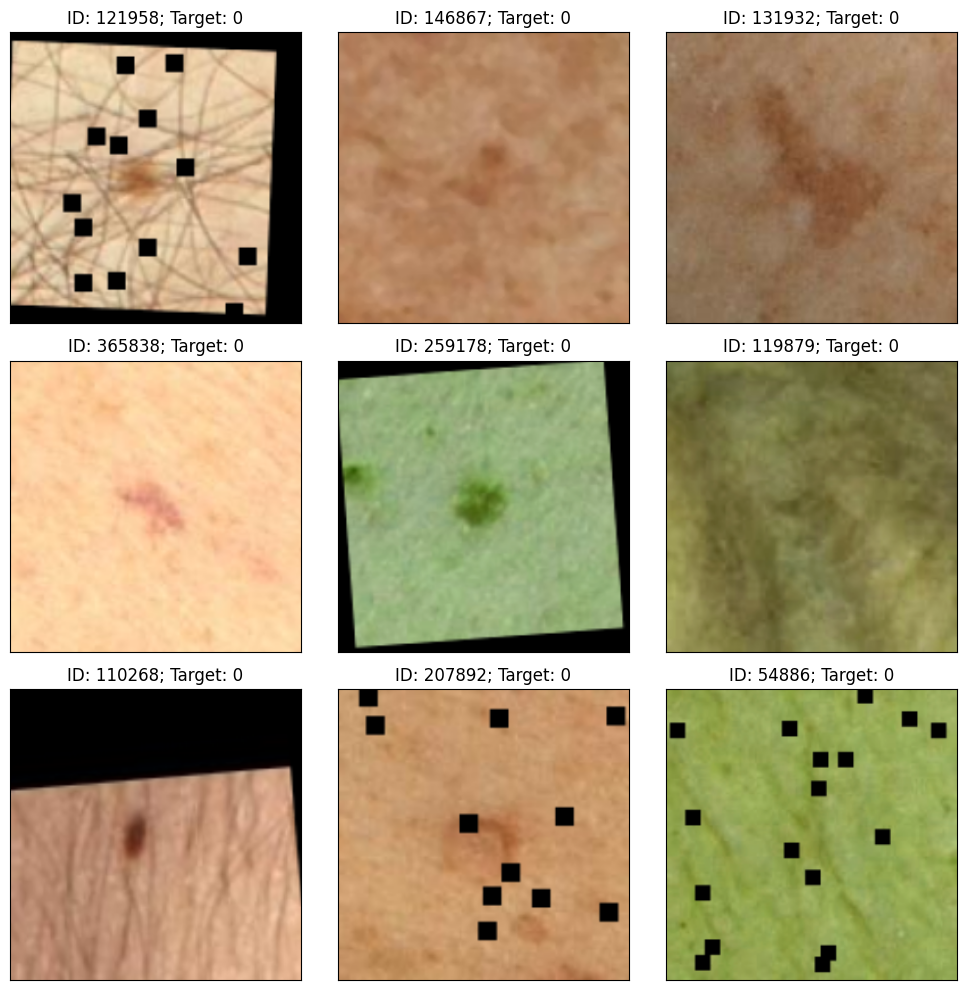

In [94]:
if not CFG.is_infer:


    if CFG.view:
        def show_batch(ds, row=3, col=3, color='rgb'):
            fig = plt.figure(figsize=(10, 10))
            img_index = np.random.randint(0, len(ds)-1, row*col)
            
            for i in range(len(img_index)):
                img, label = ds[img_index[i]]
                img_rgb = img[:3, :, :]
                # img_hsv = img[3:6, :, :]
                
                if color=='rgb':
                    img = img_rgb
                # elif color=='hsv':
                #     img = img_hsv
                
                if isinstance(img, torch.Tensor):
                    img = img.detach().numpy()
                    # Check if the image is in (C, H, W) and transpose it to (H, W, C)
                    if img.shape[0] == 3:  # Assuming the image is (C, H, W)
                        img = np.transpose(img, (1, 2, 0))
                
                ax = fig.add_subplot(row, col, i + 1, xticks=[], yticks=[])
                ax.imshow(img)  # Remove cmap parameter for RGB images
                ax.set_title(f'ID: {img_index[i]}; Target: {label}')
            
            plt.tight_layout()
            plt.show()

        _train_transform, _ = get_transforms()
        if CFG.alldata_isic_archive:
            _dataset = ISICDataset(df=train_meta, fp_hdf=CFG.TRAIN_HDF5_COMBINED, transform=_train_transform)
        else:
            _dataset = ISICDataset(df=train_meta, fp_hdf=CFG.TRAIN_HDF5, transform=_train_transform)
        show_batch(_dataset)
        # show_batch(_dataset, color='hsv')


# 7. Training

In [95]:
if not CFG.is_infer:


    # reference
    def train_one_fold(val_fold: int, 
                    train: pd.DataFrame,
                    output_path: str|Path
                    ):
        """Main"""
        # If True, forces cuDNN to benchmark multiple convolution algorithms and choose the fastest one
        torch.backends.cudnn.benchmark = True
        set_random_seed(CFG.random_seed, deterministic=CFG.deterministic)
        # set device with pytorch env
        device = torch.device(CFG.device)
        # print(device)
        
        train_transform, val_transform = get_transforms()
        
    #     train_dataset = Bird2024Dataset(**train_path_label, transform=train_transform)
        if CFG.alldata_isic_archive:
            train_dataset = ISICDataset(train[train['fold']!=val_fold], CFG.TRAIN_HDF5_COMBINED, train_transform)
            train_dataset_noaugment = ISICDataset(train[train['fold']!=val_fold], CFG.TRAIN_HDF5_COMBINED, val_transform)
            val_dataset = ISICDataset(train[train['fold']==val_fold], CFG.TRAIN_HDF5_COMBINED, val_transform)
        else:
            train_dataset = ISICDataset(train[train['fold']!=val_fold], CFG.TRAIN_HDF5, train_transform)
            train_dataset_noaugment = ISICDataset(train[train['fold']!=val_fold], CFG.TRAIN_HDF5, val_transform)
            val_dataset = ISICDataset(train[train['fold']==val_fold], CFG.TRAIN_HDF5, val_transform)
        
        train_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=CFG.batch_size, num_workers=4, shuffle=True, drop_last=True)
        train_loader_noaugment = torch.utils.data.DataLoader(
            train_dataset_noaugment, batch_size=CFG.batch_size, num_workers=4, shuffle=True, drop_last=True)
        
        val_loader = torch.utils.data.DataLoader(
            val_dataset, batch_size=CFG.batch_size, num_workers=4, shuffle=False, drop_last=False)
        
        model = timmModel(
            model_name=CFG.model_name, 
            pretrained=CFG.pretrained, 
            num_classes=0, # no classification head
            in_channels=6, # RBG+HSV
            is_training=True
        )
        # transfer learning
        if CFG.PRETRAINED_MODEL:
            model.initialize_dummy()
            model.load_state_dict(torch.load(CFG.PRETRAINED_MODEL, map_location=device))
            
        model = model.to(device)

        
        optimizer = optim.AdamW(params=model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
        scheduler = lr_scheduler.OneCycleLR(
            optimizer=optimizer, epochs=CFG.max_epoch,
            pct_start=0.0, steps_per_epoch=len(train_loader),
            max_lr=CFG.lr, div_factor=25, final_div_factor=1e4
        )
        
    #     loss_func = KLDivLossWithLogits()
        # loss_func = nn.CrossEntropyLoss()
        # loss_func = nn.BCEWithLogitsLoss()
    #     loss_func = FocalLossBCE()
        # loss_func.to(device)
    #     loss_func_val = KLDivLossWithLogitsForVal()
    #     loss_func_val = nn.CrossEntropyLoss()
        # loss_func_val = nn.BCEWithLogitsLoss()
    #     loss_func_val = FocalLossBCE()
        
        use_amp = CFG.enable_amp
        scaler = amp.GradScaler('cuda', enabled=use_amp)
        # scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
        
        best_val_loss = 1.0e+09
        best_epoch = 0
        train_loss = 0
        val_loss = 0
        cumulative_elapsed_time = 0
        
        for epoch in range(1, CFG.max_epoch + 1):
            if CFG.change_dataset & epoch >= ((CFG.max_epoch+1) * 0.6):
                train_loader = train_loader_noaugment
            epoch_start = time()
            model.train()
            for batch in tqdm(train_loader):
                
                x, t = batch
                if CFG.standardization:
                    x = (x - x.min()) / (x.max() - x.min() +1e-6) * 255
                else:
                    x = x.float()/255
                # t = t.float()
    #             print(x)
    #             print(t)
                x = to_device(x, device)
                t = to_device(t, device)
                    
                optimizer.zero_grad()
                # with torch.cuda.amp.autocast(use_amp):
                with amp.autocast('cuda', enabled=use_amp):
                    output = model(x, t)
                    loss = output['bce_loss']
                
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
                train_loss += loss.item()
                scheduler.step()
                
            train_loss /= len(train_loader)
                
            model.eval()
            for batch in tqdm(val_loader):
                x, t = batch
                if CFG.standardization:
                    x = (x - x.min()) / (x.max() - x.min() +1e-6) * 255
                else:
                    x = x.float()/255
                x = to_device(x, device)
                t = to_device(t, device)
                # with torch.no_grad(), torch.cuda.amp.autocast(use_amp):
                with torch.no_grad(), amp.autocast('cuda', enabled=use_amp):
                    output = model(x, t)
                loss = output['bce_loss']
                val_loss += loss.item()
            val_loss /= len(val_loader)
            
            if val_loss < best_val_loss:
                best_epoch = epoch
                best_val_loss = val_loss
                # print("save model")
                torch.save(model.state_dict(), str(output_path / f'snapshot_epoch_{epoch}.pth'))
            
            elapsed_time = time() - epoch_start
            cumulative_elapsed_time += elapsed_time
            with open(str(output_path / f'train_log.txt'), 'a') as f:
                f.write('\n')
                f.write(f'exp: {CFG.exp}, [epoch {epoch}] train loss: {train_loss: .6f}, val loss: {val_loss: .6f}, elapsed_time: {elapsed_time: .3f}')
            
            # log
            if CFG.enable_wandb:
                wandb.log({"Train Loss": train_loss, 
                        "Val Loss": val_loss, 
                        "Cumulative Time(m)": cumulative_elapsed_time/60,
                        "Fold": val_fold}
                        )
            print(
                f"[epoch {epoch}] train loss: {train_loss: .6f}, val loss: {val_loss: .6f}, cumulative_elapsed_time: {cumulative_elapsed_time/60: .1f}m , elapsed_time: {elapsed_time/60: .3f}m")
            
            
            
            if epoch - best_epoch > CFG.es_patience:
                with open(str(output_path / f'train_log.txt'), 'a') as f:
                    f.write('\n')
                    f.write("Early Stopping!")
                print("Early Stopping!")
                break
                
            train_loss = 0
            val_loss = 0
                
        return val_fold, best_epoch, best_val_loss

### delete previous exp data

In [96]:
if not CFG.is_infer:


    # select the best model and delete others
    best_log_list = []
    for (fold_id) in range(CFG.n_folds):
        
        # select the best model
        exp_dir_path = CFG.OUTPUT_DIR / f"fold{fold_id}"        
        for p in exp_dir_path.glob("*.pth"):
            # delete
            p.unlink()
        for p in exp_dir_path.glob("*.txt"):
            # delete
            p.unlink()

### Train  

In [97]:
if not CFG.is_infer:

    score_list = []
    print('='*20)
    print('experiment: ', CFG.exp)
    print('='*20)
    for fold_id in range(CFG.n_folds):
        output_path = CFG.OUTPUT_DIR / f"fold{fold_id}"
        output_path.mkdir(exist_ok=True, parents=True)
        print(f"[fold{fold_id}]")
        score_list.append(train_one_fold(fold_id, train_meta, output_path))
        
    with open(CFG.OUTPUT_LOG, 'a') as f:
        f.write('\n')
        f.write(f'exp: {CFG.exp}')
        f.write('\n')
        f.write(str(score_list))

experiment:  46
[fold0]


/tmp/ipykernel_2890391/174359630.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(CFG.PRETRAINED_MODEL, map_location=device))


  0%|          | 0/2553 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 512.00 MiB. GPU 0 has a total capacity of 15.60 GiB of which 91.75 MiB is free. Process 1070746 has 534.00 MiB memory in use. Process 815557 has 534.00 MiB memory in use. Process 1671389 has 1.93 GiB memory in use. Process 1856106 has 12.46 GiB memory in use. Of the allocated memory 1.48 GiB is allocated by PyTorch, and 171.17 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

# 8. Validation

In [ ]:
if not CFG.is_infer:

    print(score_list)
    score_list_log = score_list

In [ ]:
if not CFG.is_infer:


    # select the best model and delete others
    best_log_list = []
    for (fold_id, best_epoch, _) in score_list:
        
        # select the best model
        exp_dir_path = CFG.OUTPUT_DIR / f"fold{fold_id}"
        best_model_path = exp_dir_path / f"snapshot_epoch_{best_epoch}.pth"
        # copy to new place
        copy_to = CFG.OUTPUT_DIR / f"./best_model_fold{fold_id}.pth"
        shutil.copy(best_model_path, copy_to)
        
        for p in exp_dir_path.glob("*.pth"):
            # delete
            p.unlink()
        # for p in exp_dir_path.glob("*.txt"):
        #     # delete
        #     p.unlink()

In [ ]:
# Function for inference
def run_inference_loop(model, loader, device):
    model.to(device)
    model.eval()
    model.output_type = ['infer']
    pred_list = []
    with torch.no_grad():
        for batch in tqdm(loader):
            x = to_device(batch[0], device)
            if CFG.standardization:
                x = (x - x.min()) / (x.max() - x.min() +1e-6) * 255
            else:
                x = x.float()/255
            output = model(x)
            y = output['target']
            pred_list.append(y.detach().cpu().numpy())
    
    # concatenate to vertical (to df like from long scroll like)
    pred_arr = np.concatenate(pred_list)
    del pred_list
    return pred_arr

### Prediction

In [ ]:
if not CFG.is_infer:


    # predict for train data with metrix(CV. not test data)


    # duplicate check
    column_to_check = 'isic_id'
    # Drop duplicate rows based on the specified column
    train_meta = train_meta.drop_duplicates(subset=[column_to_check], keep='first').reset_index(drop=True)

    # label_arr = train[CLASSES].values
    oof_pred_arr = np.zeros((len(train_meta), CFG.n_classes-1))
    if CFG.TTA:
        oof_pred_arr_TTA = np.zeros((len(train_meta), CFG.n_classes-1))
    score_list = []

    for fold_id in range(CFG.n_folds):
        print(f"\n[fold {fold_id}]")
        device = torch.device(CFG.device)

        # get_dataloader
        val_transform_TTA, val_transform = get_transforms()
        if CFG.alldata_isic_archive:
            val_dataset = ISICDataset(df=train_meta[train_meta["fold"] == fold_id], fp_hdf=CFG.TRAIN_HDF5_COMBINED, transform=val_transform)
            val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=CFG.batch_size, num_workers=4, shuffle=False, drop_last=False)
            if CFG.TTA:
                val_dataset_TTA = ISICDataset(df=train_meta[train_meta["fold"] == fold_id], fp_hdf=CFG.TRAIN_HDF5_COMBINED, transform=val_transform_TTA)
                val_loader_TTA = torch.utils.data.DataLoader(val_dataset_TTA, batch_size=CFG.batch_size, num_workers=4, shuffle=False, drop_last=False)
        else:
            val_dataset = ISICDataset(df=train_meta[train_meta["fold"] == fold_id], fp_hdf=CFG.TRAIN_HDF5, transform=val_transform)
            val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=CFG.batch_size, num_workers=4, shuffle=False, drop_last=False)
            if CFG.TTA:
                val_dataset_TTA = ISICDataset(df=train_meta[train_meta["fold"] == fold_id], fp_hdf=CFG.TRAIN_HDF5, transform=val_transform_TTA)
                val_loader_TTA = torch.utils.data.DataLoader(val_dataset_TTA, batch_size=CFG.batch_size, num_workers=4, shuffle=False, drop_last=False)

        # # get model
        model_path = CFG.OUTPUT_DIR / f"best_model_fold{fold_id}.pth"
        model = timmModel(
            model_name=CFG.model_name, 
            pretrained=False, 
            in_channels=6,
            num_classes=0,
            is_training=False
        )
        model.initialize_dummy()  # Initialize with dummy data for dynamic linear
        model.load_state_dict(torch.load(model_path, map_location=device))

        # # inference
        val_pred = run_inference_loop(model, val_loader, device)
        val_idx = train_meta[train_meta["fold"] == fold_id].index.values
        oof_pred_arr[val_idx] = val_pred
        if CFG.TTA:
            val_pred_TTA = run_inference_loop(model, val_loader_TTA, device)
            val_idx_TTA = train_meta[train_meta["fold"] == fold_id].index.values
            oof_pred_arr_TTA[val_idx_TTA] = val_pred_TTA

        del val_idx
        del model, val_loader
        torch.cuda.empty_cache()
        gc.collect()
    


### Merging

In [ ]:
if not CFG.is_infer:
    if CFG.TTA:
        # ref. CFG.TTA_rate = {'None':value, 'with_train_aug':value}
        oof_pred_arr_merged = (oof_pred_arr * CFG.TTA_rate['None']) + (oof_pred_arr_TTA * CFG.TTA_rate['with_train_aug'])

### test of averaged model

In [ ]:
# test of averaged model
if CFG.test_of_averaged_model:
    # predict for train data with metrix(CV. not test data)


    # duplicate check
    column_to_check = 'isic_id'
    # Drop duplicate rows based on the specified column
    train_meta = train_meta.drop_duplicates(subset=[column_to_check], keep='first').reset_index(drop=True)

    # label_arr = train[CLASSES].values
    oof_pred_arr = np.zeros((len(train_meta), CFG.n_classes-1))
    score_list = []

    for fold_id in range(1):
        print(f"\n[fold {fold_id}]")
        device = torch.device(CFG.device)

        # get_dataloader
        _, val_transform = get_transforms()
        val_dataset = ISICDataset(df=train_meta, fp_hdf=CFG.TRAIN_HDF5_COMBINED, transform=val_transform)
        val_loader = torch.utils.data.DataLoader(
            val_dataset, batch_size=CFG.batch_size, num_workers=4, shuffle=False, drop_last=False)

        # # get model
        model_path = CFG.OUTPUT_DIR / f"averaged_model.pth"
        model = timmModel(
            model_name=CFG.model_name, 
            pretrained=False, 
            in_channels=6,
            num_classes=0,
            is_training=False
        )
        model.initialize_dummy()  # Initialize with dummy data for dynamic linear
        model.load_state_dict(torch.load(model_path, map_location=device))

        # # inference
        val_pred = run_inference_loop(model, val_loader, device)
        # val_idx = train_meta[train_meta["fold"] == fold_id].index.values
        oof_pred_arr = val_pred

        del val_idx
        del model, val_loader
        torch.cuda.empty_cache()
        gc.collect()

### Metrix

In [ ]:
def comp_score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str, min_tpr: float=0.80):
    v_gt = abs(np.asarray(solution.values)-1)
    v_pred = np.array([1.0 - x for x in submission.values])
    max_fpr = abs(1-min_tpr)
    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    # change scale from [0.5, 1.0] to [0.5 * max_fpr**2, max_fpr]
    # https://math.stackexchange.com/questions/914823/shift-numbers-into-a-different-range
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)
    return partial_auc


### CV Score

In [ ]:
if not CFG.is_infer:

    # make true array
    label_arr = train_meta['target']
    # one-hot
    # ture_arr = np.zeros((label_arr.size, CFG.n_classes))
    # ture_arr[np.arange(label_arr.size), label_arr] = 1
    ture_arr = pd.DataFrame(label_arr)

    # oof
    oof = pd.DataFrame(oof_pred_arr)
    if CFG.TTA:
        oof = pd.DataFrame(oof_pred_arr_merged)

    micro_roc_auc_ovr = comp_score(
        ture_arr,
        oof,
        ""
    )

    print(f"CV: Micro-averaged One-vs-Rest ROC AUC score:\n{micro_roc_auc_ovr:.10f}")
    if CFG.enable_wandb:
        wandb.log({"CV": micro_roc_auc_ovr})


In [ ]:
if not CFG.is_infer:

    with open(CFG.OUTPUT_LOG, 'a') as f:
        f.write('\n')
        f.write(f'exp: {CFG.exp}')
        f.write('\n')
        f.write(f"CV: Micro-averaged One-vs-Rest ROC AUC score: {micro_roc_auc_ovr:.10f}")

In [ ]:
if not CFG.is_infer:

    display(oof.head())
    display(ture_arr.head())
    display(oof.tail())
    display(ture_arr.tail())

# 9. Inference

In [ ]:
# predict for test data with metrix
if (CFG.is_kaggle & CFG.is_infer) or CFG.use_tabler:

    pred_arr = []
    pred_arr_TTA = []

    for fold_id in range(CFG.n_folds):
        print(f"\n[fold {fold_id}]")
        device = torch.device(CFG.device)

        # get_dataloader
        val_transform_TTA, val_transform = get_transforms()
        val_dataset = ISICDataset(df=test_meta, fp_hdf=CFG.TEST_HDF5, transform=val_transform)
        val_loader = torch.utils.data.DataLoader(
            val_dataset, batch_size=CFG.batch_size, num_workers=2, shuffle=False, drop_last=False)
        if CFG.TTA:
            val_dataset_TTA = ISICDataset(df=test_meta, fp_hdf=CFG.TEST_HDF5, transform=val_transform_TTA)
            val_loader_TTA = torch.utils.data.DataLoader(
                val_dataset_TTA, batch_size=CFG.batch_size, num_workers=2, shuffle=False, drop_last=False)

        # get model
        model_path = CFG.OUTPUT_DIR / f"best_model_fold{fold_id}.pth"
        model = timmModel(
            model_name=CFG.model_name, 
            pretrained=False, 
            in_channels=6,
            num_classes=0,
            is_training=False
        )
        model.initialize_dummy()
        model.load_state_dict(torch.load(model_path, map_location=device))

        # # inference
        val_pred = run_inference_loop(model, val_loader, device)
        pred_arr.append(val_pred)
        if CFG.TTA:
            val_pred_TTA = run_inference_loop(model, val_loader_TTA, device)
            pred_arr_TTA.append(val_pred_TTA)

        del model, val_loader, val_pred
        if CFG.TTA:
            del val_loader_TTA, val_pred_TTA
        torch.cuda.empty_cache()
        gc.collect()
        
    # averaging
    print(len(pred_arr))
    if len(pred_arr) >= 2:    
        pred_arr = np.mean(pred_arr, axis=0)
    print(pred_arr.shape)
    
    if CFG.TTA:
        print(len(pred_arr_TTA))
        if len(pred_arr_TTA) >= 2:    
            pred_arr_TTA = np.mean(pred_arr_TTA, axis=0)
        print(pred_arr_TTA.shape)

        pred_arr = (pred_arr * CFG.TTA_rate['None']) + (pred_arr_TTA * CFG.TTA_rate['with_train_aug'])


    pred_df = pd.DataFrame(pred_arr, columns=['target'])
    display(pred_df)

    # submission
    df_sub = pd.read_csv(CFG.SAMPLE_SUB)
    df_sub["target"] = pred_df
    display(df_sub.head())
    df_sub.to_csv('submission.csv', index=False)
 
    



[fold 0]


/opt/conda/lib/python3.10/site-packages/albumentations/augmentations/blur/transforms.py:180: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  warnings.warn(
/tmp/ipykernel_2890391/1866852127.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]


[fold 1]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]


[fold 2]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]


[fold 3]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]


[fold 4]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

5
(3, 1)
5
(3, 1)


,target
0,0.000322
1,0.000016
2,0.000036


,isic_id,target
0,ISIC_0015657,0.000322
1,ISIC_0015729,0.000016
2,ISIC_0015740,0.000036


# 10. Tabler

In [ ]:
if CFG.use_tabler:
    image_pred_col = 'image_prediction'
    
    if not CFG.is_infer:
        # add image model prediction to train_meta as a feature
        
        oof = pd.DataFrame(oof_pred_arr, columns=[image_pred_col])
        display(oof.head())
        assert len(oof) == len(train_meta)
        train_meta[image_pred_col] = oof[image_pred_col].values
        # train_meta = train_meta.merge(oof[image_pred_col], 
        #                       on='isic_id', 
        #                       how='left')
        
    # add using feature
    if CFG.image_pred_as_tabler_feature:
        feature_cols.append(image_pred_col)

    # add image model prediction to test_meta as a feature
    assert len(pred_df) == len(test_meta)
    display(pred_df)
    test_meta[image_pred_col] = pred_df['target'].values
    # test_meta = test_meta.merge(pred_df[image_pred_col], 
    #                       on='isic_id', 
    #                       how='left')
    # already added  
    # feature_cols.append(image_pred_col)

,target
0,0.000322
1,0.000016
2,0.000036


### 10.1 Optuna HyperParam Tuned Models

##### 10.1.1 LGBM

In [ ]:
if CFG.use_tabler and ((not CFG.is_infer) or (not CFG.image_pred_as_tabler_feature)):
    lgb_params = {
        'objective':        'binary',
        'verbosity':        -1,
        'n_iter':           200,
        'boosting_type':    'gbdt',
        'random_state':     seed,
        'lambda_l1':        0.08758718919397321, 
        'lambda_l2':        0.0039689175176025465, 
        'learning_rate':    0.03231007103195577, 
        'max_depth':        4, 
        'num_leaves':       103, 
        'colsample_bytree': 0.8329551585827726, 
        'colsample_bynode': 0.4025961355653304, 
        'bagging_fraction': 0.7738954452473223, 
        'bagging_freq':     4, 
        'min_data_in_leaf': 85, 
        'scale_pos_weight': 2.7984184778875543,
    }

    lgb_model = Pipeline([
        ('sampler', RandomUnderSampler(sampling_strategy=sampling_ratio, random_state=seed)),
        ('classifier', lgb.LGBMClassifier(**lgb_params)),
    ])

##### 10.1.2 CatBoost

In [ ]:
if CFG.use_tabler and ((not CFG.is_infer) or (not CFG.image_pred_as_tabler_feature)):
    cb_params = {
        'loss_function':     'Logloss',
        'iterations':        200,
        'verbose':           False,
        'random_state':      seed,
        'max_depth':         7, 
        'learning_rate':     0.06936242010150652, 
        'scale_pos_weight':  2.6149345838209532, 
        'l2_leaf_reg':       6.216113851699493, 
        'subsample':         0.6249261779711819, 
        'min_data_in_leaf':  24,
        'cat_features':      cat_cols,
    }

    cb_model = Pipeline([
        ('sampler', RandomUnderSampler(sampling_strategy=sampling_ratio, random_state=seed)),
        ('classifier', cb.CatBoostClassifier(**cb_params)),
    ])

##### 10.1.3 XGBoost

In [ ]:
if CFG.use_tabler and ((not CFG.is_infer) or (not CFG.image_pred_as_tabler_feature)):
    xgb_params = {
        'enable_categorical': True,
        'tree_method':        'hist',
        'random_state':       seed,
        'learning_rate':      0.08501257473292347, 
        'lambda':             8.879624125465703, 
        'alpha':              0.6779926606782505, 
        'max_depth':          6, 
        'subsample':          0.6012681388711075, 
        'colsample_bytree':   0.8437772277074493, 
        'colsample_bylevel':  0.5476090898823716, 
        'colsample_bynode':   0.9928601203635129, 
        'scale_pos_weight':   3.29440313334688,
    }

    xgb_model = Pipeline([
        ('sampler', RandomUnderSampler(sampling_strategy=sampling_ratio, random_state=seed)),
        ('classifier', xgb.XGBClassifier(**xgb_params)),
    ])

In [ ]:
if CFG.use_tabler and ((not CFG.is_infer) or (not CFG.image_pred_as_tabler_feature)):
    estimator = VotingClassifier([
        ('lgb', lgb_model), ('cb', cb_model), ('xgb', xgb_model),
    ], voting='soft')

### 10.2 CV

In [ ]:
if CFG.use_tabler and ((not CFG.is_infer)):
    # Assuming df_train already has a 'fold' column with values 0-4
    X = train_meta[feature_cols]
    y = train_meta[target_col]

    # Create a PredefinedSplit object using the 'fold' column
    fold_indices = train_meta['fold'].values
    cv = PredefinedSplit(fold_indices)

    # if CFG.is_infer: # inference
    #     with open(str(CFG.OUTPUT_DIR / f'voting_classifier.pkl'), 'rb') as file:
    #         estimator = pickle.load(file)
    # Perform cross-validation
    val_score = cross_val_score(
        estimator=estimator, 
        X=X, y=y, 
        cv=cv,
        scoring=custom_metric,
    )

    print(np.mean(val_score), val_score)
    if CFG.enable_wandb:
        wandb.log({"tabler_CV": np.mean(val_score)})

### 10.3 Training

In [ ]:
if CFG.use_tabler and ((not CFG.is_infer) or (not CFG.image_pred_as_tabler_feature)):
    X, y = train_meta[feature_cols], train_meta[target_col]

    estimator.fit(X, y)
    # save
    if not CFG.is_kaggle:
        with open(str(CFG.OUTPUT_DIR / f'voting_classifier.pkl'), 'wb') as file:
            pickle.dump(estimator, file)


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


### 10.4 Prediction

In [ ]:
if CFG.use_tabler:
    
    if CFG.is_infer: # inference
        with open(str(CFG.OUTPUT_DIR / f'voting_classifier.pkl'), 'rb') as file:
            estimator = pickle.load(file)
        df_subm['target'] = estimator.predict_proba(test_meta[feature_cols])[:, 1]
        df_subm.to_csv('submission.csv')
    else: # training
        df_subm['target'] = estimator.predict_proba(test_meta[feature_cols])[:, 1]
        
    if CFG.ensemble_image_table:
        # image prediction
        print('image pred')
        display(pred_df)
        # table prediction
        print('table pred')
        display(df_subm)
        # blending
        df_subm['target'] = (df_subm['target'].values * 0.5) + (pred_df['target'].values * 0.5)
        df_subm.to_csv('submission.csv')
        
        
        print('blended pred')
        display(df_subm.head())

image pred


,target
0,0.000322
1,0.000016
2,0.000036


table pred


,target
isic_id,
ISIC_0015657,0.496691
ISIC_0015729,0.281504
ISIC_0015740,0.459656


blended pred


,target
isic_id,
ISIC_0015657,0.248507
ISIC_0015729,0.140760
ISIC_0015740,0.229846


### Score

In [ ]:
if CFG.ensemble_image_table:

    # make true array
    label_arr = train_meta['target']
    # one-hot
    # ture_arr = np.zeros((label_arr.size, CFG.n_classes))
    # ture_arr[np.arange(label_arr.size), label_arr] = 1
    ture_arr = pd.DataFrame(label_arr)

    # pred
    pred = estimator.predict_proba(train_meta[feature_cols])[:, 1]
    pred = pd.DataFrame(pred)

    micro_roc_auc_ovr = comp_score(
        ture_arr,
        pred,
        ""
    )

    print(f"CV: Micro-averaged One-vs-Rest ROC AUC score:\n{micro_roc_auc_ovr:.10f}")
    if CFG.enable_wandb:
        wandb.log({"CV": micro_roc_auc_ovr})

CV: Micro-averaged One-vs-Rest ROC AUC score:
0.1983782371


### Importance Visualization

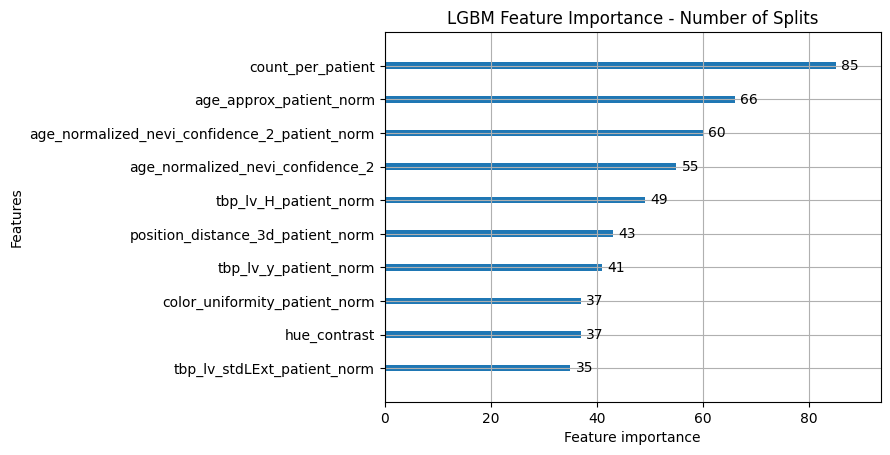

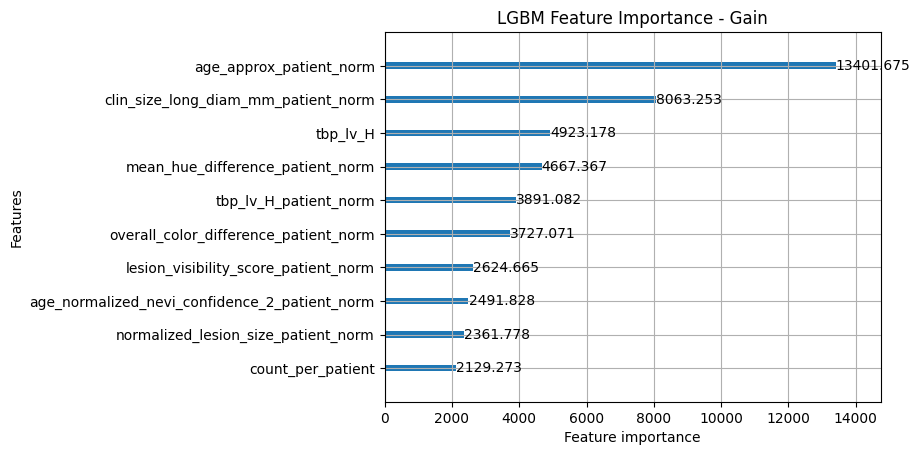

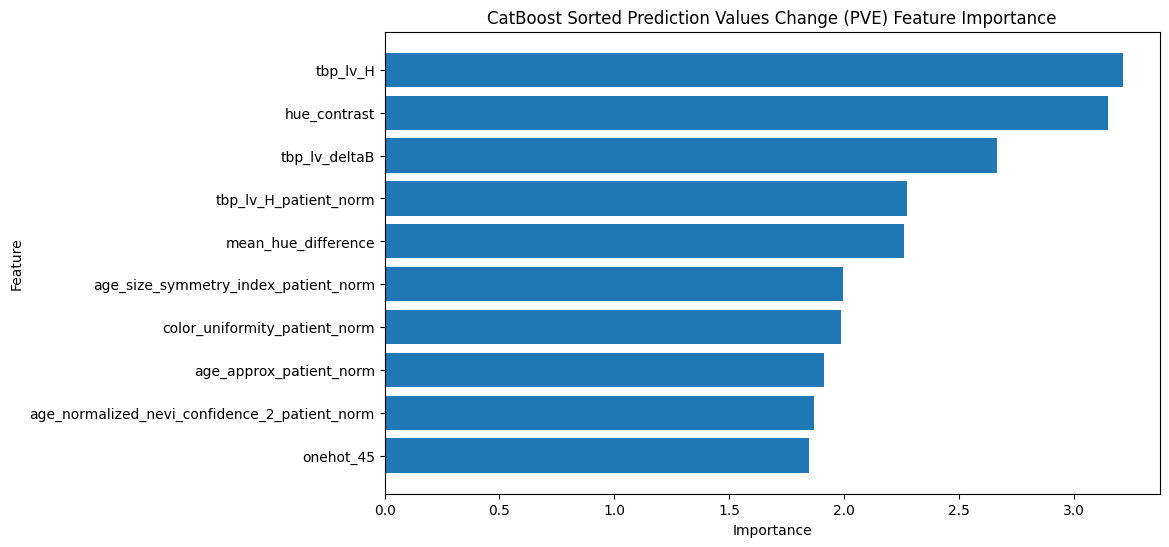

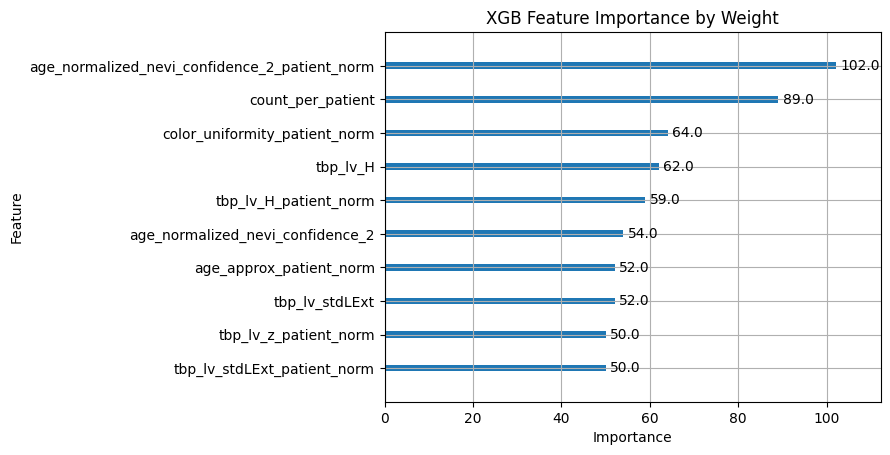

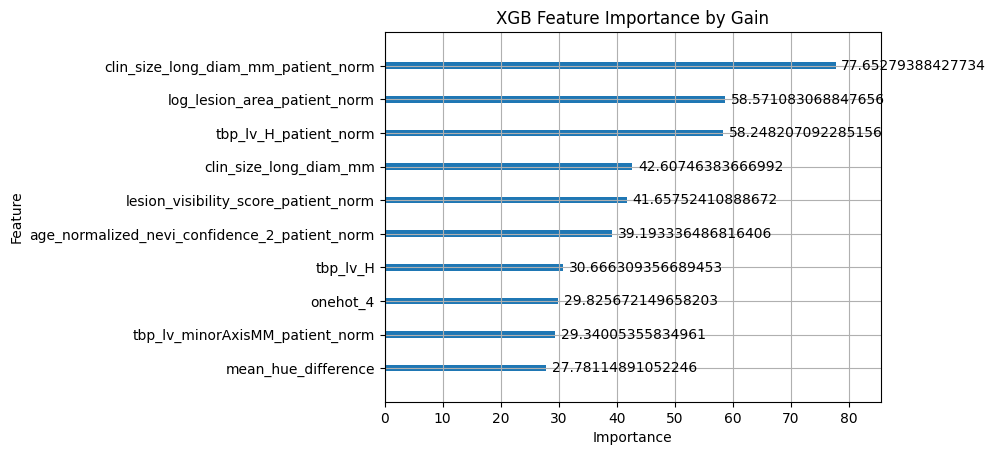

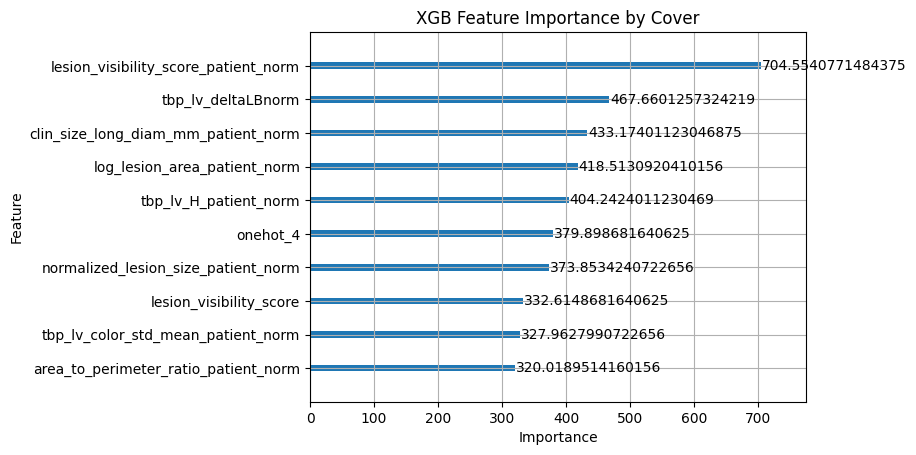

In [ ]:
for model in estimator.estimators_:
    model = model['classifier']
    model_name = str(model)
    model_name_list = ['LGBM', 'catboost', 'XGB']
    number_of_show = 10
    if model_name_list[0] in model_name:
        lgb.plot_importance(model, max_num_features=number_of_show, importance_type='split')
        plt.title('LGBM Feature Importance - Number of Splits')
        plt.show()
        lgb.plot_importance(model, max_num_features=number_of_show, importance_type='gain')
        plt.title('LGBM Feature Importance - Gain')
        plt.show()
    if model_name_list[1] in model_name:
        # PVC
        pve_importances = model.get_feature_importance(type='PredictionValuesChange') # default type
        sorted_indices = np.argsort(pve_importances)[-number_of_show:]
        plt.figure(figsize=(10, 6))
        plt.barh(np.array(feature_cols)[sorted_indices], pve_importances[sorted_indices])
        plt.xlabel('Importance')
        plt.ylabel('Feature')
        plt.title('CatBoost Sorted Prediction Values Change (PVE) Feature Importance')
        plt.show()
        # # Shapley
        # shap_values = model.get_feature_importance(cb.Pool(X,y), type='ShapValues')
        # shap_importances = np.mean(np.abs(shap_values[:, :-1]), axis=0)
        # sorted_indices = np.argsort(shap_importances)[-number_of_show:]
        # plt.figure(figsize=(10, 6))
        # plt.barh(np.array(feature_cols)[sorted_indices], shap_importances[sorted_indices])
        # plt.xlabel('Importance')
        # plt.ylabel('Feature')
        # plt.title('CatBoost Sorted Shapley Values Feature Importance')
        # plt.show()
    if model_name_list[2] in model_name:
        xgb.plot_importance(model, importance_type='weight', title='XGB Feature Importance by Weight', xlabel='Importance', ylabel='Feature', max_num_features=number_of_show)
        plt.show()

        xgb.plot_importance(model, importance_type='gain', title='XGB Feature Importance by Gain', xlabel='Importance', ylabel='Feature', max_num_features=number_of_show)
        plt.show()

        xgb.plot_importance(model, importance_type='cover', title='XGB Feature Importance by Cover', xlabel='Importance', ylabel='Feature', max_num_features=number_of_show)
        plt.show()



### save dfs

In [ ]:
# save the dfs
if (not CFG.is_infer) and (not CFG.is_kaggle):
    train_meta.to_parquet(CFG.OUTPUT_DIR / 'train_meta.parquet', index=False)
    test_meta.to_parquet(CFG.OUTPUT_DIR / 'test_meta.parquet', index=False)